<a href="https://colab.research.google.com/github/Colsai/DATA602_DA_ML/blob/main/DATA602_Project_NBK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DATA602: FINAL PROJECT (Krishnamoorthy)
## *Chicago Public Schools: Modeling Best Predictors on Graduation Rate using multiple regression models*

### Utilization of Multiple Machine Learning Models to predict school graduation rates based on highly-correlating features.

- This is a pilot model that could eventually be turned into a larger analysis and model, depending on the success in this single dataset. 

- The purpose of this notebook is to continue an exploration of Chicago Public High Schools, and propose an ML model that can accurately predict a target average of graduation rates for schools. 

- After feature selection and analysis, this model could eventually be applied to other years of data, but will only focus on the most recent year for Chicago Public Schools. Multiple years were not selected, as there are issues with data consistency, etc.

- Finally, using a model with the highest metric accuracy, I will draw conclusions based on how the model is predicting the quality of the school itself.

## Background


In [912]:
!pip install missingno

#Import Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import time
import missingno as msno
from statsmodels.graphics.gofplots import qqplot
from IPython.display import clear_output
import sklearn
%matplotlib inline

clear_output()
pd.__version__

'1.1.5'

In [913]:
#Import each dataset (Chicago Public Schools)
start_time = time.time()

df = pd.read_csv("https://data.cityofchicago.org/api/views/dw27-rash/rows.csv?accessType=DOWNLOAD&bom=true&format=true")

dur = time.time()- start_time

print(f"{round(dur,3)}s")

1.717s


In [914]:
df.shape

(654, 182)

## Helper Functions for the Notebook
Some helper functions used in the notebook that are called multiple times.

In [915]:
#Display Function for Variables
def show_all(input_list, line_len = 3) -> list:
    """Display custom number of items per columns"""
    num_in_line = 0

    for elem in input_list:
        if num_in_line > line_len - 1:
            print(f"")
            print(elem, end = ', ')
            num_in_line = 0
        
        else:
            print(elem, end = ', ')
        
        num_in_line += 1

#Function to show percent of nulls in col
def show_nulls(df) -> np.array:
    """Show and return number and percent of nulls of data"""
    try:
        return [df.isna().sum(), round(df.isna().sum()/len(df),2)]
    except:
        print("There was an issue with the data")
        return False

#Return Correlations Function
def correlation_return(dataframe_, series_, num = 25) -> np.array:
    """For returning correlations, dataframe_,series_,num returned"""
    corr = dataframe_.corr()
    return (abs(corr[series_]).sort_values(ascending = False)[0:num])

#Subtract one list from another
def subtract_lists(list1, list2) -> list:
    """Returns a selected list of values of items that are in the first list but not the second"""
    return [item for item in list1 if item not in list2]

## Hypothesis:

*H0: Disparate factors for the model*
*H1: *

# I. Exploratory Data Analysis of Dataset
- Initial Check through the Data

In [916]:
df.head()

,School_ID,Short_Name,Long_Name,School_Type,Primary_Category,Address,City,State,Zip,Phone,Fax,CPS_School_Profile,Website,Progress_Report_Year,Blue_Ribbon_Award_Year,Excelerate_Award_Gold_Year,Spot_Light_Award_Year,Improvement_Award_Year,Excellence_Award_Year,Student_Growth_Rating,Student_Growth_Description,Growth_Reading_Grades_Tested_Pct_ES,Growth_Reading_Grades_Tested_Label_ES,Growth_Math_Grades_Tested_Pct_ES,Growth_Math_Grades_Tested_Label_ES,Student_Attainment_Rating,Student_Attainment_Description,Attainment_Reading_Pct_ES,Attainment_Reading_Lbl_ES,Attainment_Math_Pct_ES,Attainment_Math_Lbl_ES,Culture_Climate_Rating,Culture_Climate_Description,School_Survey_Student_Response_Rate_Pct,School_Survey_Student_Response_Rate_Avg_Pct,School_Survey_Teacher_Response_Rate_Pct,School_Survey_Teacher_Response_Rate_Avg_Pct,School_Survey_Parent_Response_Rate_Pct,School_Survey_Parent_Response_Rate_Avg_Pct,Healthy_School_Certification,...,College_Persistence_School_Pct_Year_2,College_Persistence_CPS_Pct_Year_2,College_Persistence_School_Pct_Year_1,College_Persistence_CPS_Pct_Year_1,Progress_Toward_Graduation_Year_1,Progress_Toward_Graduation_Year_2,State_School_Report_Card_URL,Mobility_Rate_Pct,Chronic_Truancy_Pct,Empty_Progress_Report_Message,School_Survey_Rating_Description,Supportive_School_Award,Supportive_School_Award_Desc,Parent_Survey_Results_Year,School_Latitude,School_Longitude,PSAT_Grade_9_Score_School_Avg,PSAT_Grade_10_Score_School_Avg,SAT_Grade_11_Score_School_Avg,SAT_Grade_11_Score_CPS_Avg,Growth_PSAT_Grade_9_School_Pct,Growth_PSAT_Grade_9_School_Lbl,Growth_PSAT_Reading_Grade_10_School_Pct,Growth_PSAT_Reading_Grade_10_School_Lbl,Growth_SAT_Grade_11_School_Pct,Growth_SAT_Grade_11_School_Lbl,Attainment_PSAT_Grade_9_School_Pct,Attainment_PSAT_Grade_9_School_Lbl,Attainment_PSAT_Grade_10_School_Pct,Attainment_PSAT_Grade_10_School_Lbl,Attainment_SAT_Grade_11_School_Pct,Attainment_SAT_Grade_11_School_Lbl,Attainment_All_Grades_School_Pct,Attainment_All_Grades_School_Lbl,Growth_PSAT_Math_Grade_10_School_Pct,Growth_PSAT_Math_Grade_10_School_Lbl,Growth_SAT_Reading_Grade_11_School_Pct,Growth_SAT_Reading_Grade_11_School_Lbl,Growth_SAT_Math_Grade_11_School_Pct,Growth_SAT_Math_Grade_11_School_Lbl
0,"609,710",HARLAN HS,John M Harlan Community Academy High School,Neighborhood,HS,9652 S MICHIGAN AVE,Chicago,Illinois,"60,628","7,735,355,400","7,735,355,061",http://cps.edu/Schools/Pages/school.aspx?Schoo...,https://www.harlanfalcons.org,"2,018",NaN,NaN,NaN,NaN,NaN,BELOW AVERAGE,Student Growth measures the change in standard...,NaN,NaN,NaN,NaN,FAR BELOW EXPECTATIONS,Student Attainment measures how well the schoo...,NaN,NaN,NaN,NaN,PARTIALLY ORGANIZED,Results are based on student and teacher respo...,76.6,81.4,80.0,79.9,41%,35.6,Not Achieved,...,45.5,72.3,56.9,71.9,"2,017","2,018",http://iirc.niu.edu/School.aspx?schoolid=15016...,33.9,89.4,NaN,This school is “Partially Organized for Improv...,EMERGING,This school has developed an action plan to su...,"2,018",41.718372,-87.620623,701,733,824,969.0,2.0,2nd,32.0,32nd,9.0,9th,8.3,8.3,4.8,4.8,5.6,5.6,6.2,6.2,7.0,7th,50.0,50th,50.0,50th
1,"610,059",MAYER,Oscar Mayer Magnet School,Magnet,ES,2250 N CLIFTON AVE,Chicago,Illinois,"60,614","7,735,345,535","7,735,345,777",http://cps.edu/Schools/Pages/school.aspx?Schoo...,http://mayermagnet.org/,"2,018",NaN,NaN,NaN,"2,013",NaN,AVERAGE,Student Growth measures the change in standard...,58.0,58th,47.0,47th,FAR ABOVE AVERAGE,Student Attainment measures how well the schoo...,96.0,96th,91.0,91st,WELL ORGANIZED,Results are based on student and teacher respo...,98.9,81.4,79.1,79.9,> 75%,35.6,Not Achieved,...,NaN,72.3,NaN,71.9,"2,017","2,018",http://iirc.niu.edu/School.aspx?schoolid=15016...,3.8,22.9,NaN,This school is “Well-Organized for Improvement...,EMERGING,This school has developed an action plan to su...,"2,018",41.923204,-87.657287,NaN,NaN,NaN,969.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"610,334",RABY HS,Al Raby High Sch

In [917]:
#Introduce the four years' datasets
show_all(df, line_len = 10)

School_ID, Short_Name, Long_Name, School_Type, Primary_Category, Address, City, State, Zip, Phone, 
Fax, CPS_School_Profile, Website, Progress_Report_Year, Blue_Ribbon_Award_Year, Excelerate_Award_Gold_Year, Spot_Light_Award_Year, Improvement_Award_Year, Excellence_Award_Year, Student_Growth_Rating, 
Student_Growth_Description, Growth_Reading_Grades_Tested_Pct_ES, Growth_Reading_Grades_Tested_Label_ES, Growth_Math_Grades_Tested_Pct_ES, Growth_Math_Grades_Tested_Label_ES, Student_Attainment_Rating, Student_Attainment_Description, Attainment_Reading_Pct_ES, Attainment_Reading_Lbl_ES, Attainment_Math_Pct_ES, 
Attainment_Math_Lbl_ES, Culture_Climate_Rating, Culture_Climate_Description, School_Survey_Student_Response_Rate_Pct, School_Survey_Student_Response_Rate_Avg_Pct, School_Survey_Teacher_Response_Rate_Pct, School_Survey_Teacher_Response_Rate_Avg_Pct, School_Survey_Parent_Response_Rate_Pct, School_Survey_Parent_Response_Rate_Avg_Pct, Healthy_School_Certification, 
Healthy_School_Certifi

## Establish the focus of the dataset here (High Schools)
- Our focus here will be to look at only Chicago High Schools- it is difficult to use other types of schools to look at Educational outcomes as we do not really know what they look like. 

In [918]:
df = df[df['Graduation_4_Year_School_Pct_Year_2'].notna()]

In [919]:
#Subset Data by being high schools and not having feature variable as null
high_schools = df[df['Primary_Category'] == 'HS']
high_schools = high_schools[high_schools['Graduation_4_Year_School_Pct_Year_2'].notna()]

In [920]:
high_schools

,School_ID,Short_Name,Long_Name,School_Type,Primary_Category,Address,City,State,Zip,Phone,Fax,CPS_School_Profile,Website,Progress_Report_Year,Blue_Ribbon_Award_Year,Excelerate_Award_Gold_Year,Spot_Light_Award_Year,Improvement_Award_Year,Excellence_Award_Year,Student_Growth_Rating,Student_Growth_Description,Growth_Reading_Grades_Tested_Pct_ES,Growth_Reading_Grades_Tested_Label_ES,Growth_Math_Grades_Tested_Pct_ES,Growth_Math_Grades_Tested_Label_ES,Student_Attainment_Rating,Student_Attainment_Description,Attainment_Reading_Pct_ES,Attainment_Reading_Lbl_ES,Attainment_Math_Pct_ES,Attainment_Math_Lbl_ES,Culture_Climate_Rating,Culture_Climate_Description,School_Survey_Student_Response_Rate_Pct,School_Survey_Student_Response_Rate_Avg_Pct,School_Survey_Teacher_Response_Rate_Pct,School_Survey_Teacher_Response_Rate_Avg_Pct,School_Survey_Parent_Response_Rate_Pct,School_Survey_Parent_Response_Rate_Avg_Pct,Healthy_School_Certification,...,College_Persistence_School_Pct_Year_2,College_Persistence_CPS_Pct_Year_2,College_Persistence_School_Pct_Year_1,College_Persistence_CPS_Pct_Year_1,Progress_Toward_Graduation_Year_1,Progress_Toward_Graduation_Year_2,State_School_Report_Card_URL,Mobility_Rate_Pct,Chronic_Truancy_Pct,Empty_Progress_Report_Message,School_Survey_Rating_Description,Supportive_School_Award,Supportive_School_Award_Desc,Parent_Survey_Results_Year,School_Latitude,School_Longitude,PSAT_Grade_9_Score_School_Avg,PSAT_Grade_10_Score_School_Avg,SAT_Grade_11_Score_School_Avg,SAT_Grade_11_Score_CPS_Avg,Growth_PSAT_Grade_9_School_Pct,Growth_PSAT_Grade_9_School_Lbl,Growth_PSAT_Reading_Grade_10_School_Pct,Growth_PSAT_Reading_Grade_10_School_Lbl,Growth_SAT_Grade_11_School_Pct,Growth_SAT_Grade_11_School_Lbl,Attainment_PSAT_Grade_9_School_Pct,Attainment_PSAT_Grade_9_School_Lbl,Attainment_PSAT_Grade_10_School_Pct,Attainment_PSAT_Grade_10_School_Lbl,Attainment_SAT_Grade_11_School_Pct,Attainment_SAT_Grade_11_School_Lbl,Attainment_All_Grades_School_Pct,Attainment_All_Grades_School_Lbl,Growth_PSAT_Math_Grade_10_School_Pct,Growth_PSAT_Math_Grade_10_School_Lbl,Growth_SAT_Reading_Grade_11_School_Pct,Growth_SAT_Reading_Grade_11_School_Lbl,Growth_SAT_Math_Grade_11_School_Pct,Growth_SAT_Math_Grade_11_School_Lbl
0,"609,710",HARLAN HS,John M Harlan Community Academy High School,Neighborhood,HS,9652 S MICHIGAN AVE,Chicago,Illinois,"60,628","7,735,355,400","7,735,355,061",http://cps.edu/Schools/Pages/school.aspx?Schoo...,https://www.harlanfalcons.org,"2,018",NaN,NaN,NaN,NaN,NaN,BELOW AVERAGE,Student Growth measures the change in standard...,NaN,NaN,NaN,NaN,FAR BELOW EXPECTATIONS,Student Attainment measures how well the schoo...,NaN,NaN,NaN,NaN,PARTIALLY ORGANIZED,Results are based on student and teacher respo...,76.6,81.4,80.0,79.9,41%,35.6,Not Achieved,...,45.5,72.3,56.9,71.9,"2,017","2,018",http://iirc.niu.edu/School.aspx?schoolid=15016...,33.9,89.4,NaN,This school is “Partially Organized for Improv...,EMERGING,This school has developed an action plan to su...,"2,018",41.718372,-87.620623,701,733,824,969.0,2.0,2nd,32.0,32nd,9.0,9th,8.3,8.3,4.8,4.8,5.6,5.6,6.2,6.2,7.0,7th,50.0,50th,50.0,50th
2,"610,334",RABY HS,Al Raby High School,Small,HS,3545 W FULTON BLVD,Chicago,Illinois,"60,624","7,735,346,755","7,735,346,938",http://cps.edu/Schools/Pages/school.aspx?Schoo...,http://www.alraby.org/,"2,018",NaN,NaN,NaN,NaN,NaN,BELOW AVERAGE,Student Growth measures the change in standard...,NaN,NaN,NaN,NaN,FAR BELOW EXPECTATIONS,Student Attainment measures how well the schoo...,NaN,NaN,NaN,NaN,WELL ORGANIZED,Results are based on student and teacher respo...,74.1,81.4,76.9,79.9,< 30%,35.6,Not Achieved,...,54.5,72.3,51.1,71.9,"2,017","2,018",http://iirc.niu.edu/School.aspx?schoolid=15016...,10.9,85.7,NaN,This school is “Well-Organized for Improvement...,ESTABLISHED,This school has put in place systems and struc...,"2,018",41.886210,-87.715423,685,756,814,969.0,1.0,1st,68.0,68th,3.0,3rd,4.8,4.8,0.0,0.0,3.5,3.5,2.7,2.7,16.0,16th,50.0,50th,63.0,63rd
9,"609,712",HIRSCH HS,Emil G 

In [921]:
high_schools['Graduation_4_Year_School_Pct_Year_2'][high_schools['Graduation_4_Year_School_Pct_Year_2'].isna() == True]

Series([], Name: Graduation_4_Year_School_Pct_Year_2, dtype: float64)

In [922]:
#Dataframe Shape
high_schools.shape

(140, 182)

In [923]:
high_schools.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140 entries, 0 to 625
Columns: 182 entries, School_ID to Growth_SAT_Math_Grade_11_School_Lbl
dtypes: float64(92), object(90)
memory usage: 200.2+ KB


# II. Data Cleaning and Feature Selection
Our target here will be to analyze graduation rates, so here I will select for
-any graduation-related features that target 'year_2' 
- ('year_2' variables are the most-recent year, and a better indicator for school success)

In [924]:
#What variables here could be selected for a look at graduation rates?
grad_y2 = [col for col in high_schools.columns if ('gradua' in col.lower()) and ('year_2' in col.lower())]
print(grad_y2)

['Graduation_4_Year_School_Pct_Year_2', 'Graduation_4_Year_CPS_Pct_Year_2', 'Graduation_5_Year_School_Pct_Year_2', 'Graduation_5_Year_CPS_Pct_Year_2', 'Progress_Toward_Graduation_Year_2']


In [925]:
high_schools[grad_y2].head(10)

,Graduation_4_Year_School_Pct_Year_2,Graduation_4_Year_CPS_Pct_Year_2,Graduation_5_Year_School_Pct_Year_2,Graduation_5_Year_CPS_Pct_Year_2,Progress_Toward_Graduation_Year_2
0,56.1,75.6,65.7,78.2,"2,018"
2,68.5,75.6,73.1,78.2,"2,018"
9,55.0,75.6,45.5,78.2,"2,018"
10,84.4,75.6,91.2,78.2,"2,018"
17,30.3,75.6,38.3,78.2,"2,018"
19,89.0,75.6,85.7,78.2,"2,018"
27,82.5,75.6,90.7,78.2,"2,018"
33,87.1,75.6,95.5,78.2,"2,018"
37,96.2,75.6,90.6,78.2,"2,018"
41,96.5,75.6,91.8,78.2,"2,018"


From the results, there really are only a few variables here that are of help. 
- Graduation_4_Year_CPS_PCT_Year_2 is just the average of all CPS, as is the 5_year_CPS_PCT_Year_2. 
- Progress_Toward_Graduation_Year_2 is the most-recent year the data was collected.

In [926]:
#For now, let's set our target variable as 4_year_pct and 5_year_pct
target_grad_rate = ['Graduation_4_Year_School_Pct_Year_2', 
                    'Graduation_5_Year_School_Pct_Year_2']

#How many null values are there here?                    
high_schools[target_grad_rate].isna().sum() / len(high_schools)

Graduation_4_Year_School_Pct_Year_2    0.00
Graduation_5_Year_School_Pct_Year_2    0.05
dtype: float64

In [927]:
#List cleaned_cols will hold the cols data
cleaned_cols = []

In [928]:
show_nulls(high_schools['Graduation_4_Year_School_Pct_Year_2'])

[0, 0.0]

In [929]:
show_nulls(high_schools['Graduation_5_Year_School_Pct_Year_2'])

[7, 0.05]

In [930]:
#What are the highest correlating factors?
correlation_return(high_schools, 'Graduation_4_Year_School_Pct_Year_2', num = 5)

NWEA_Math_Growth_Grade_4_Pct           1.0
NWEA_Math_Growth_Grade_3_Pct           1.0
Graduation_4_Year_School_Pct_Year_2    1.0
NWEA_Reading_Growth_Grade_4_Pct        1.0
NWEA_Reading_Attainment_Grade_5_Pct    1.0
Name: Graduation_4_Year_School_Pct_Year_2, dtype: float64

In [931]:
pd.DataFrame(high_schools['Graduation_4_Year_CPS_Pct_Year_2'])

,Graduation_4_Year_CPS_Pct_Year_2
0,75.6
2,75.6
9,75.6
10,75.6
17,75.6
...,...
601,75.6
602,75.6
609,75.6
618,75.6


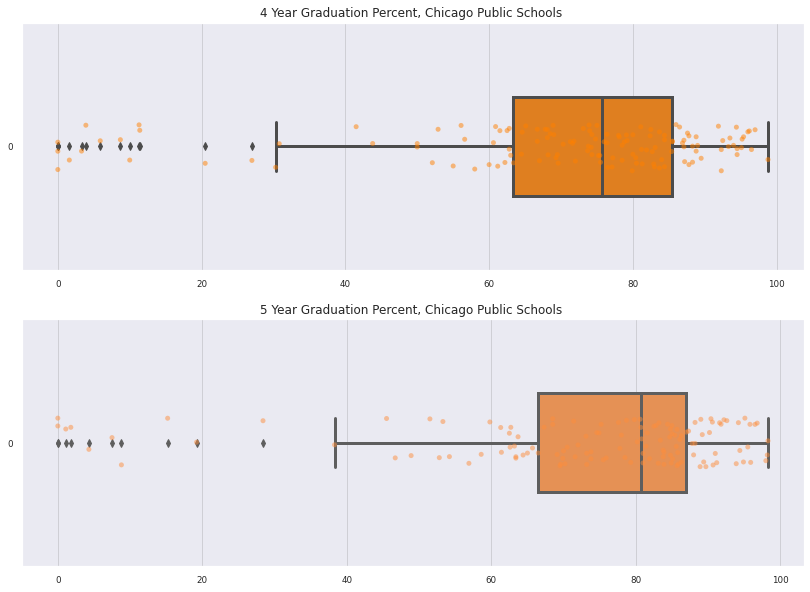

In [932]:
#Visualize the two featurees
fig, ax = plt.subplots(2,1,figsize=(14,10),sharex=False, sharey=False)
sns.set_theme()
sns.set(font_scale= 1.5)

pov_dfs = [high_schools['Graduation_4_Year_School_Pct_Year_2'],high_schools['Graduation_5_Year_School_Pct_Year_2']]
pov_titles = ['4 Year Graduation Percent', '5 Year Graduation Percent']
colors = ['autumn_r', 'Oranges_r']
for i in range(0,2):
    ax[i].set_title(f"{pov_titles[i]}, Chicago Public Schools ", size = 12)
    ax[i].grid(color='gray', alpha = .5, linestyle='-', linewidth=.5)
    
    sns.boxplot(
                data = pov_dfs[i],
                width = .4,
                linewidth = 3,
                palette =  colors[i],
                ax = ax[i],
                orient = "h")

    sns.stripplot(
                alpha = .5, 
                data = pov_dfs[i],
                palette = colors[i],
                ax = ax[i],
                orient = "h")

Naturally, the graduation rate for 5 years is higher and has a lower standard deviation than the graduation rate for 4 year graduation percent.

Frighteningly, some of the graduation rates here for Chicago Public Schools are at 0 or very near 0.

In [933]:
high_schools['Graduation_4_Year_School_Pct_Year_2'].value_counts(bins = 5, sort = False)

(-0.0998, 19.76]    11
(19.76, 39.52]       4
(39.52, 59.28]      10
(59.28, 79.04]      56
(79.04, 98.8]       59
Name: Graduation_4_Year_School_Pct_Year_2, dtype: int64

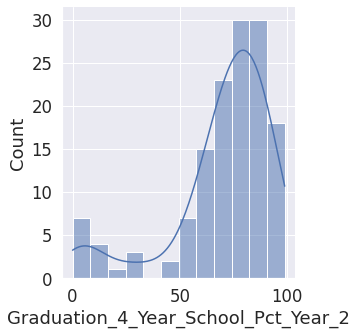

In [934]:
#Graphing the Distribution of Graduation Scores
sns.displot(high_schools['Graduation_4_Year_School_Pct_Year_2'], kde = True)

In [935]:
high_schools['Graduation_5_Year_School_Pct_Year_2'].value_counts(bins = 5, sort = False)

(-0.0993, 19.66]     9
(19.66, 39.32]       2
(39.32, 58.98]       9
(58.98, 78.64]      41
(78.64, 98.3]       72
Name: Graduation_5_Year_School_Pct_Year_2, dtype: int64

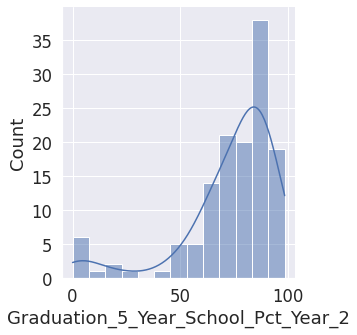

In [936]:
#Graphing the Distribution of Graduation Scores
sns.displot(high_schools['Graduation_5_Year_School_Pct_Year_2'], kde = True)

In [937]:
high_schools[['Short_Name', 'Graduation_4_Year_School_Pct_Year_2', 'Graduation_5_Year_School_Pct_Year_2']].sort_values(by = 'Graduation_4_Year_School_Pct_Year_2', ascending = True)

,Short_Name,Graduation_4_Year_School_Pct_Year_2,Graduation_5_Year_School_Pct_Year_2
402,NORTHSIDE LEARNING HS,0.0,0.0
601,VAUGHN HS,0.0,19.2
100,CAMELOT - EXCEL SOUTHWEST HS,0.0,NaN
609,YORK HS,1.6,1.1
177,OMBUDSMAN - SOUTH HS,3.3,NaN
...,...,...,...
114,PAYTON HS,96.0,98.2
37,CARVER MILITARY HS,96.2,90.6
41,BACK OF THE YARDS HS,96.5,91.8
602,YOUNG HS,97.0,95.9


## Analysis:
'York High School', one of the lowest-ranking high schools in Chicago Public Schools, has a very low graduation rate0 1.6. Somehow, it has an even lower rate for 5 year graduation rate. These issues are reflected in extra information on school performance.

https://www.publicschoolreview.com/york-alternative-high-school-profile

## What this suggests:
This school performance indicates obvious school issues that are affecting performance. In the next section, feature selection, I will look to identify which features those are, and finally look to create a model, analyze model performance, and draw summary conclusions based on what I see.


## Data Cleaning and Feature Selection
Removing some useless or unhelpful columns
- year_2 values are values for the most-recent year. 
- Since those numbers are more relevant than year_1 (the previous year's) numbers, we'll keep those

In [938]:
high_schools.columns[4:13]

Index(['Primary_Category', 'Address', 'City', 'State', 'Zip', 'Phone', 'Fax',
       'CPS_School_Profile', 'Website'],
      dtype='object')

### Removing Data:
- Explaining the removal of data columns here:
Categorical Desc Cols: This removes several categorical variables that will not be used (address, etc.)

- High Null Cols: This removes any columns that do not have at least 75% of the data present as nulls (for any items that have nulls -- some data in other columns is also entered as 'NO DATA AVAILABLE', etc.)

- Description Cols: Description Cols serve to explain a type of feature, but are not helpful for the actual analysis here. They'll be removed.

- Years Cols: The dataset contains values from both this and last year. We'll only want to look at the most recent data here, any data that is 'year_2'. We'll skip the year_1 data.

- Label Data: Label Cols are also columns that have descriptive data that is not helpful for the dataset here. 

In [939]:
#Create lists of columns for removal
categorical_desc_cols = high_schools.columns[4:13] #Remove some categorical data here

 #Remove any items with nulls higher than 75%
high_null_cols = [col for col in high_schools if high_schools[col].isna().sum()/len(high_schools) >= .75]

#Remove other categorical columns
description_cols = [col for col in high_schools.columns if "description" in col.lower() or "avg" in col.lower() or "cps_pct_year" in col.lower()] #Remove anything with 'description' in title, not useful here
label_cols = [col for col in high_schools.columns if "lbl" in col.lower()]
more_unused_cols = ['Address', 
                    'City', 
                    'State', 
                    'Zip', 
                    'Phone', 
                    'Fax', 
                    'Website', 
                    'Progress_Report_Year', 
                    'State_School_Report_Card_URL', 
                    'CPS_School_Profile', 
                    'School_Latitude',
                    'School_Longitude', 
                    'Other_Metrics_Year_1', 
                    'Other_Metrics_Year_2',
                    'Supportive_School_Award_Desc',
                    'Creative_School_Certification',
                    'School_Survey_Student_Response_Rate_Pct',
                    'School_Survey_Teacher_Response_Rate_Pct',
                    'School_Survey_Parent_Response_Rate_Pct']

#Remove ALL Year Columns. Then KEEP year values, but drop any values that are cps_pct_year, since they are only averages of the column
all_year_cols = [col for col in high_schools.columns if "year" in col.lower()]
year_1_cols = [col for col in high_schools.columns if ("year_1" in col.lower() and 'cps_pct_year_1' not in col.lower())]
year_2_cols = [col for col in high_schools.columns if ("year_2" in col.lower() and 'cps_pct_year_2' not in col.lower())]

#Remove a few more columns from 'Year_2' that are not used
year_2_remove = ['Progress_Toward_Graduation_Year_2', 'Other_Metrics_Year_2', 'Behavior_Discipline_Year_2']

#Combine all columns
all_cols = description_cols + [categorical_desc_cols[0]] + high_null_cols + all_year_cols + label_cols + more_unused_cols

#Set Modified Cols Here
temp_cols = [col for col in list(high_schools.columns) if col not in all_cols] + year_2_cols
temp_cols = [col for col in temp_cols if col not in year_2_remove]

#How many columns are left?
print(f"There are {len(temp_cols)} columns.")

There are 41 columns.


In [940]:
#Here is a list of possible data elements:
high_schools[temp_cols].head(1).T[0::]

,0
School_ID,"609,710"
Short_Name,HARLAN HS
Long_Name,John M Harlan Community Academy High School
School_Type,Neighborhood
Student_Growth_Rating,BELOW AVERAGE
Student_Attainment_Rating,FAR BELOW EXPECTATIONS
Culture_Climate_Rating,PARTIALLY ORGANIZED
Healthy_School_Certification,Not Achieved
School_Survey_Involved_Families,WEAK
School_Survey_Supportive_Environment,NEUTRAL


In [941]:
show_all(high_schools[temp_cols].columns)

School_ID, Short_Name, Long_Name, 
School_Type, Student_Growth_Rating, Student_Attainment_Rating, 
Culture_Climate_Rating, Healthy_School_Certification, School_Survey_Involved_Families, 
School_Survey_Supportive_Environment, School_Survey_Ambitious_Instruction, School_Survey_Effective_Leaders, 
School_Survey_Collaborative_Teachers, School_Survey_Safety, School_Survey_School_Community, 
School_Survey_Parent_Teacher_Partnership, School_Survey_Quality_Of_Facilities, Mobility_Rate_Pct, 
Chronic_Truancy_Pct, Supportive_School_Award, Growth_PSAT_Grade_9_School_Pct, 
Growth_PSAT_Reading_Grade_10_School_Pct, Growth_SAT_Grade_11_School_Pct, Attainment_PSAT_Grade_9_School_Pct, 
Attainment_PSAT_Grade_10_School_Pct, Attainment_SAT_Grade_11_School_Pct, Attainment_All_Grades_School_Pct, 
Growth_PSAT_Math_Grade_10_School_Pct, Growth_SAT_Reading_Grade_11_School_Pct, Growth_SAT_Math_Grade_11_School_Pct, 
Suspensions_Per_100_Students_Year_2_Pct, Misconducts_To_Suspensions_Year_2_Pct, Average_Length_Susp

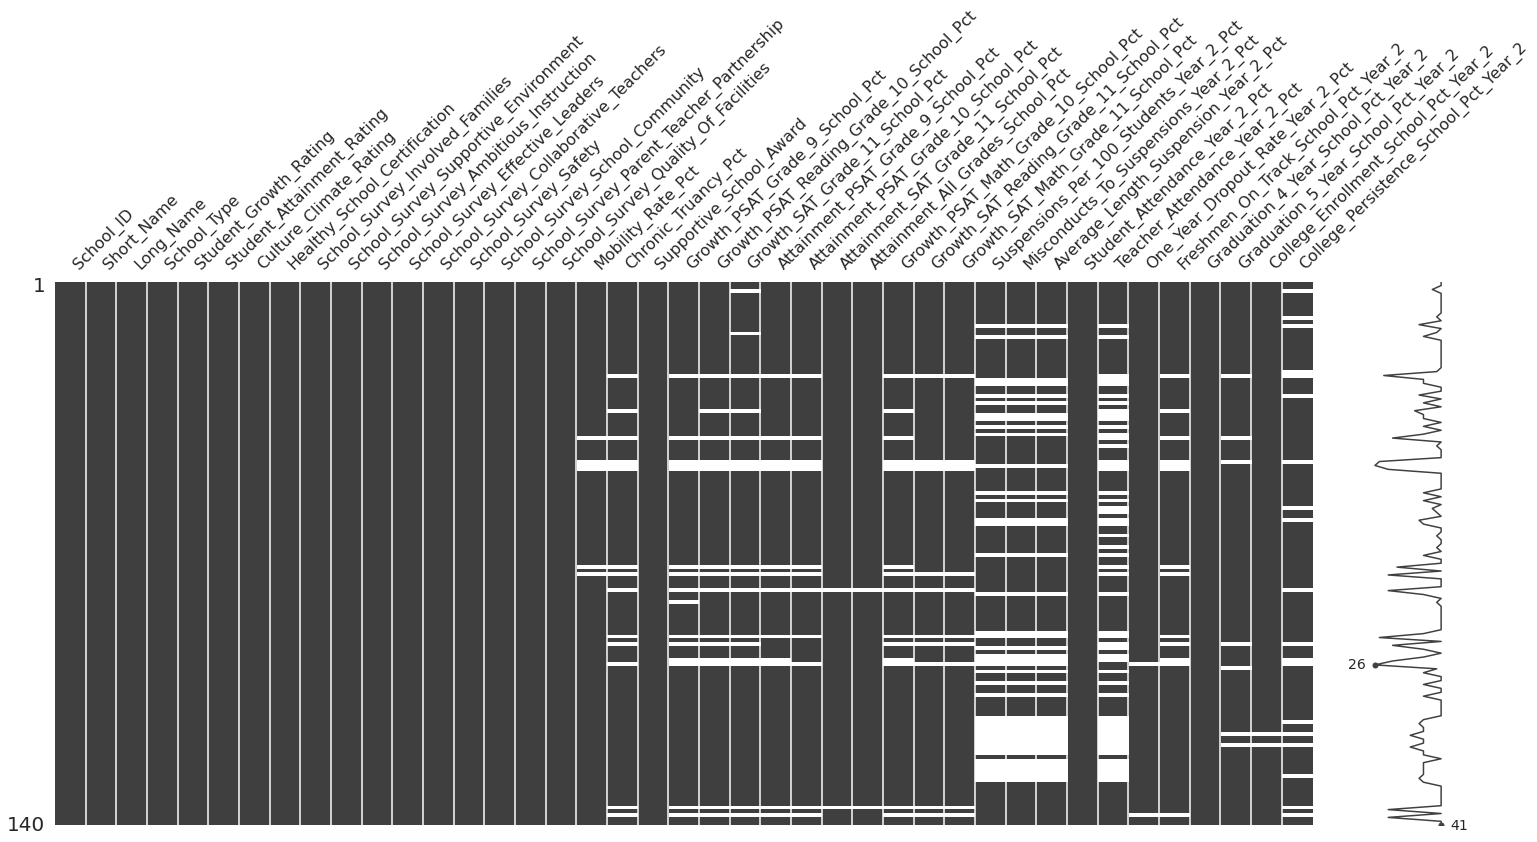

In [942]:
#Visualizing the number of nulls here
msno.matrix(high_schools[temp_cols])

In [943]:
high_schools[temp_cols].head(1).T[0::]

,0
School_ID,"609,710"
Short_Name,HARLAN HS
Long_Name,John M Harlan Community Academy High School
School_Type,Neighborhood
Student_Growth_Rating,BELOW AVERAGE
Student_Attainment_Rating,FAR BELOW EXPECTATIONS
Culture_Climate_Rating,PARTIALLY ORGANIZED
Healthy_School_Certification,Not Achieved
School_Survey_Involved_Families,WEAK
School_Survey_Supportive_Environment,NEUTRAL


In [944]:
high_schools[temp_cols].head(1).T[35:70]

,0
One_Year_Dropout_Rate_Year_2_Pct,9.9
Freshmen_On_Track_School_Pct_Year_2,68.8
Graduation_4_Year_School_Pct_Year_2,56.1
Graduation_5_Year_School_Pct_Year_2,65.7
College_Enrollment_School_Pct_Year_2,62.3
College_Persistence_School_Pct_Year_2,45.5


## Change the 'Average_Length_Suspension' column
This column has day values, but contains string objects '# DAY', rather than float values. We'll convert this into numerical values for teh data. 

In [945]:
high_schools['Average_Length_Suspension_Year_2_Pct'].dtypes

dtype('O')

In [946]:
high_schools['Average_Length_Suspension_Year_2_Pct'].fillna("0 days")

0      2.1 days
2      2.0 days
9      2.5 days
10     2.0 days
17     2.2 days
         ...   
601    1.7 days
602    1.6 days
609    0.0 days
618    2.2 days
625    2.5 days
Name: Average_Length_Suspension_Year_2_Pct, Length: 140, dtype: object

In [947]:
#Impute Days column as nonnan first, then impute all other values as the mean.
try:
  avg_len_numerical = [float(elem.split()[0]) if pd.notnull(elem) == True else elem for elem in high_schools['Average_Length_Suspension_Year_2_Pct']]
except:
  print("Error")

cleaned_col = pd.Series(avg_len_numerical).fillna(value = np.mean(np.nanmean(avg_len_numerical)))

#Reset Index and Add Values Into The Dataframe
high_schools.reset_index(drop = True, inplace = True)
high_schools['Average_Length_Suspension_Year_2_Pct'] = cleaned_col

In [948]:
#One Hot Encode School Type
pd.get_dummies(high_schools['School_Type'], prefix = '', prefix_sep= "")

,Career academy,Charter,Citywide-Option,Contract,Magnet,Military academy,Neighborhood,Selective enrollment,Small,Special Education
0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
135,0,0,0,0,0,0,0,0,0,1
136,0,0,0,0,0,0,0,1,0,0
137,0,0,1,0,0,0,0,0,0,0
138,0,0,0,0,0,0,0,0,1,0


In [949]:
high_schools[temp_cols].head(2).T

,0,1
School_ID,"609,710","610,334"
Short_Name,HARLAN HS,RABY HS
Long_Name,John M Harlan Community Academy High School,Al Raby High School
School_Type,Neighborhood,Small
Student_Growth_Rating,BELOW AVERAGE,BELOW AVERAGE
Student_Attainment_Rating,FAR BELOW EXPECTATIONS,FAR BELOW EXPECTATIONS
Culture_Climate_Rating,PARTIALLY ORGANIZED,WELL ORGANIZED
Healthy_School_Certification,Not Achieved,Not Achieved
School_Survey_Involved_Families,WEAK,NEUTRAL
School_Survey_Supportive_Environment,NEUTRAL,NEUTRAL


In [950]:
high_schools[temp_cols].info(verbose = False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140 entries, 0 to 139
Columns: 41 entries, School_ID to College_Persistence_School_Pct_Year_2
dtypes: float64(23), object(18)
memory usage: 45.0+ KB


# III. Converting and imputing ordinal data
There are two main challenges for imputing and converting categorical data into numerical data. 
- Student_Growth_Rating, Student_Attainment_Rating, Culture_Climate_Rating, Supportive_School_Award, Healthy_School_Certification
- Survey Data (any col with 'survey' in it)

In [951]:
#Since these 
cat_data_cols = ['Student_Growth_Rating', 
                'Student_Attainment_Rating', 
                'Culture_Climate_Rating', 
                'Supportive_School_Award', 
                'Healthy_School_Certification']

for col in cat_data_cols:
    print(high_schools[col].value_counts(normalize = True, sort = True))

AVERAGE              0.571429
BELOW AVERAGE        0.207143
ABOVE AVERAGE        0.121429
NO DATA AVAILABLE    0.078571
FAR ABOVE AVERAGE    0.021429
Name: Student_Growth_Rating, dtype: float64
FAR BELOW EXPECTATIONS    0.464286
BELOW EXPECTATIONS        0.228571
MET EXPECTATIONS          0.157143
ABOVE EXPECTATIONS        0.078571
FAR ABOVE EXPECTATIONS    0.057143
NO DATA AVAILABLE         0.014286
Name: Student_Attainment_Rating, dtype: float64
WELL ORGANIZED          0.542857
ORGANIZED               0.250000
PARTIALLY ORGANIZED     0.114286
MODERATELY ORGANIZED    0.050000
NOT YET ORGANIZED       0.028571
NOT ENOUGH DATA         0.014286
Name: Culture_Climate_Rating, dtype: float64
NOT RATED      0.435714
EMERGING       0.342857
ESTABLISHED    0.178571
EXEMPLARY      0.042857
Name: Supportive_School_Award, dtype: float64
Not Achieved    1.0
Name: Healthy_School_Certification, dtype: float64


**Note:** Here, we can immediately remove 'Supportive_School_Award', since NONE of the schools have achieved the ranking. Additionally, Culture_Climate_Rating does not appear to have enough data to meet our 75% criteria for choosing data - 50% of the schools have not been rated.

In [952]:
#Subtract these cols From temp_cols
temp_cols = subtract_lists(temp_cols, ['Healthy_School_Certification', 'Supportive_School_Award'])
len(temp_cols)

39

In [953]:
cat_data_cols_checked = ['Student_Growth_Rating', 'Student_Attainment_Rating', 'Culture_Climate_Rating']

In [954]:
#What are the possible values?
high_schools['Student_Growth_Rating'].value_counts()

AVERAGE              80
BELOW AVERAGE        29
ABOVE AVERAGE        17
NO DATA AVAILABLE    11
FAR ABOVE AVERAGE     3
Name: Student_Growth_Rating, dtype: int64

In [955]:
#Because these values are ordinal (there is an order to them, and I want to retain that order, I'll write a custom imputation function here)
def convert_ordinal_to_numerical(df_, impute_nulls = True):
    """This takes nominal categorical data and transforms it into a numerical value"""
    numerical_scores = []

    for val in list(df_):
        if val == 'FAR ABOVE AVERAGE' or val == 'FAR ABOVE EXPECTATIONS' or val == 'WELL ORGANIZED':
            numerical_scores.append(5)
        elif val == 'ABOVE AVERAGE' or val == 'ABOVE EXPECTATIONS' or val == 'ORGANIZED':
            numerical_scores.append(4)
        elif val == 'AVERAGE' or val == 'MET EXPECTATIONS' or val == 'MODERATELY ORGANIZED':
            numerical_scores.append(3)
        elif val == 'BELOW AVERAGE' or 'BELOW EXPECATATIONS' or val == 'PARTIALLY ORGANIZED':
            numerical_scores.append(2)
        elif val == 'FAR BELOW AVERAGE' or ' FAR BELOW EXPECTATIONS' or val == 'NOT YET ORGANIZED':
            numerical_scores.append(1)
        #I'll impute any missing values as average
        else: numerical_scores.append(np.nan)
    
    score_mean = round(np.nanmean(np.array(numerical_scores)),2)
    scores_arry = np.array(numerical_scores)

    if impute_nulls == True:    
        return np.nan_to_num(scores_arry, nan = score_mean)

    else:
        return scores_arry

In [956]:
high_schools['Student_Growth_Rating']

0          BELOW AVERAGE
1          BELOW AVERAGE
2          BELOW AVERAGE
3                AVERAGE
4          BELOW AVERAGE
             ...        
135    NO DATA AVAILABLE
136              AVERAGE
137    NO DATA AVAILABLE
138              AVERAGE
139              AVERAGE
Name: Student_Growth_Rating, Length: 140, dtype: object

In [957]:
high_schools['Student_Growth_Rating'] = convert_ordinal_to_numerical(high_schools['Student_Growth_Rating'])

In [958]:
high_schools['Student_Attainment_Rating'].value_counts()

FAR BELOW EXPECTATIONS    65
BELOW EXPECTATIONS        32
MET EXPECTATIONS          22
ABOVE EXPECTATIONS        11
FAR ABOVE EXPECTATIONS     8
NO DATA AVAILABLE          2
Name: Student_Attainment_Rating, dtype: int64

In [959]:
high_schools['Student_Attainment_Rating'] = convert_ordinal_to_numerical(high_schools['Student_Attainment_Rating'])

In [960]:
high_schools['Culture_Climate_Rating'].value_counts()

WELL ORGANIZED          76
ORGANIZED               35
PARTIALLY ORGANIZED     16
MODERATELY ORGANIZED     7
NOT YET ORGANIZED        4
NOT ENOUGH DATA          2
Name: Culture_Climate_Rating, dtype: int64

In [961]:
high_schools['Culture_Climate_Rating'] = convert_ordinal_to_numerical(high_schools['Culture_Climate_Rating'])

Those columns are now successfully converted and imputed.

In [962]:
high_schools[temp_cols].select_dtypes(include=['object']).columns

Index(['School_ID', 'Short_Name', 'Long_Name', 'School_Type',
       'School_Survey_Involved_Families',
       'School_Survey_Supportive_Environment',
       'School_Survey_Ambitious_Instruction',
       'School_Survey_Effective_Leaders',
       'School_Survey_Collaborative_Teachers', 'School_Survey_Safety',
       'School_Survey_School_Community',
       'School_Survey_Parent_Teacher_Partnership',
       'School_Survey_Quality_Of_Facilities'],
      dtype='object')

In [963]:
high_schools[temp_cols].select_dtypes(include=['object']).head(1).T

,0
School_ID,"609,710"
Short_Name,HARLAN HS
Long_Name,John M Harlan Community Academy High School
School_Type,Neighborhood
School_Survey_Involved_Families,WEAK
School_Survey_Supportive_Environment,NEUTRAL
School_Survey_Ambitious_Instruction,STRONG
School_Survey_Effective_Leaders,WEAK
School_Survey_Collaborative_Teachers,WEAK
School_Survey_Safety,WEAK


In [964]:
#Remove Cols
remove_more_cols = ['Behavior_Discipline_Year_2', 
                    'Other_Metrics_Year_2', 
                    'Progress_Toward_Graduation_Year_2']

Several of these columns can be dropped- behavior discipline year, other_metrics_year, progress_toward_graduation_year_2. 

- Average_Length_Suspension_Year_2_Pct and  needs to be converted.

In [965]:
high_schools[temp_cols].select_dtypes(include=['float64']).columns

Index(['Mobility_Rate_Pct', 'Chronic_Truancy_Pct',
       'Growth_PSAT_Grade_9_School_Pct',
       'Growth_PSAT_Reading_Grade_10_School_Pct',
       'Growth_SAT_Grade_11_School_Pct', 'Attainment_PSAT_Grade_9_School_Pct',
       'Attainment_PSAT_Grade_10_School_Pct',
       'Attainment_SAT_Grade_11_School_Pct',
       'Attainment_All_Grades_School_Pct',
       'Growth_PSAT_Math_Grade_10_School_Pct',
       'Growth_SAT_Reading_Grade_11_School_Pct',
       'Growth_SAT_Math_Grade_11_School_Pct',
       'Suspensions_Per_100_Students_Year_2_Pct',
       'Misconducts_To_Suspensions_Year_2_Pct',
       'Average_Length_Suspension_Year_2_Pct', 'Student_Attendance_Year_2_Pct',
       'Teacher_Attendance_Year_2_Pct', 'One_Year_Dropout_Rate_Year_2_Pct',
       'Freshmen_On_Track_School_Pct_Year_2',
       'Graduation_4_Year_School_Pct_Year_2',
       'Graduation_5_Year_School_Pct_Year_2',
       'College_Enrollment_School_Pct_Year_2',
       'College_Persistence_School_Pct_Year_2'],
      dtype='ob

## Transforming and imputing survey data
Looking at the data here, several columns appear to not have enough data to proceed. We'll drop them here. Setting a threshold of 10% or less of 'NOT ENOUGH DATA' (missing values here), we'll check.

In [966]:
#High School Survey Columns
hs_survey_cols = [col for col in high_schools[temp_cols].columns if "School_Survey" in col][3:]
high_schools[hs_survey_cols][3:].value_counts()

School_Survey_Effective_Leaders  School_Survey_Collaborative_Teachers  School_Survey_Safety  School_Survey_School_Community  School_Survey_Parent_Teacher_Partnership  School_Survey_Quality_Of_Facilities
NEUTRAL                          STRONG                                WEAK                  NOT ENOUGH DATA                 NOT ENOUGH DATA                           NOT ENOUGH DATA                        16
                                 NEUTRAL                               WEAK                  NOT ENOUGH DATA                 NOT ENOUGH DATA                           NOT ENOUGH DATA                        12
WEAK                             NEUTRAL                               WEAK                  NOT ENOUGH DATA                 NOT ENOUGH DATA                           NOT ENOUGH DATA                         9
STRONG                           STRONG                                WEAK                  NOT ENOUGH DATA                 NOT ENOUGH DATA                           NOT

Let's look at this a little more closely...

In [967]:
look_cols = [col for col in high_schools[temp_cols].columns if "School_Survey" in col][3:]
for col in look_cols:
    print(high_schools[col].value_counts())

NEUTRAL            61
STRONG             40
WEAK               27
VERY STRONG         5
NOT ENOUGH DATA     5
VERY WEAK           2
Name: School_Survey_Effective_Leaders, dtype: int64
STRONG             62
NEUTRAL            43
VERY STRONG        17
WEAK               14
NOT ENOUGH DATA     4
Name: School_Survey_Collaborative_Teachers, dtype: int64
WEAK               90
NEUTRAL            23
VERY WEAK          19
STRONG              4
NOT ENOUGH DATA     3
VERY STRONG         1
Name: School_Survey_Safety, dtype: int64
NOT ENOUGH DATA    104
NEUTRAL             15
STRONG              13
VERY STRONG          5
WEAK                 3
Name: School_Survey_School_Community, dtype: int64
NOT ENOUGH DATA    104
STRONG              15
NEUTRAL             13
WEAK                 4
VERY STRONG          4
Name: School_Survey_Parent_Teacher_Partnership, dtype: int64
NOT ENOUGH DATA    104
NEUTRAL             15
STRONG              14
VERY STRONG          4
WEAK                 3
Name: School_Survey

In [968]:
#Checking that function works
len(high_schools['School_Survey_Parent_Teacher_Partnership'][high_schools['School_Survey_Parent_Teacher_Partnership'] == 'NOT ENOUGH DATA'])/len(high_schools)

0.7428571428571429

In [969]:
#Return the number of columns that the percent of nulls is less than 20% of all data
thresh = .1
survey_enough_data = [col for col in look_cols if len(high_schools[col][high_schools[col] == 'NOT ENOUGH DATA'])/len(high_schools) <= thresh]
survey_enough_data

['School_Survey_Effective_Leaders',
 'School_Survey_Collaborative_Teachers',
 'School_Survey_Safety']

In [970]:
#Because these values are ordinal (there is an order to them, and I want to retain that order, I'll write a custom imputation function here)
def to_numerical_scores(df_, impute_nulls = True):
    """This takes nominal categorical data and transforms it into a numerical value"""
    numerical_scores = []

    for val in list(df_):
        if val == 'VERY STRONG':
            numerical_scores.append(5)
        elif val == 'STRONG':
            numerical_scores.append(4)
        elif val == 'NEUTRAL':
            numerical_scores.append(3)
        elif val == 'WEAK':
            numerical_scores.append(2)
        elif val == 'VERY WEAK':
            numerical_scores.append(1)
        #I'll impute any missing values as average
        else: numerical_scores.append(np.nan)
    
    score_mean = round(np.nanmean(np.array(numerical_scores)),2)
    scores_arry = np.array(numerical_scores)

    if impute_nulls == True:    
        return np.nan_to_num(scores_arry, nan = score_mean)

    else:
        return scores_arry

In [971]:
to_numerical_scores(high_schools['School_Survey_Safety'], True)

array([2.  , 2.  , 3.  , 2.  , 2.  , 2.  , 3.  , 2.  , 2.  , 2.  , 2.  ,
       3.  , 2.  , 2.  , 1.  , 2.  , 2.  , 2.  , 2.  , 2.  , 2.  , 2.  ,
       2.  , 2.  , 3.  , 2.  , 1.  , 2.11, 4.  , 2.  , 2.  , 2.  , 1.  ,
       2.  , 3.  , 1.  , 1.  , 2.  , 2.  , 2.  , 2.  , 2.  , 2.  , 2.  ,
       1.  , 2.  , 3.  , 3.  , 3.  , 4.  , 2.  , 1.  , 1.  , 2.  , 1.  ,
       2.  , 3.  , 2.  , 2.  , 3.  , 2.  , 2.  , 2.  , 2.  , 4.  , 2.  ,
       2.  , 1.  , 2.  , 2.  , 2.  , 3.  , 2.  , 3.  , 1.  , 2.  , 1.  ,
       3.  , 2.  , 5.  , 2.  , 2.  , 2.  , 2.  , 3.  , 2.  , 2.  , 2.  ,
       2.  , 2.  , 2.  , 4.  , 3.  , 2.11, 1.  , 2.  , 2.11, 3.  , 2.  ,
       2.  , 1.  , 2.  , 2.  , 2.  , 2.  , 2.  , 1.  , 2.  , 2.  , 3.  ,
       2.  , 2.  , 1.  , 2.  , 2.  , 2.  , 2.  , 2.  , 1.  , 3.  , 2.  ,
       2.  , 1.  , 2.  , 3.  , 2.  , 2.  , 2.  , 2.  , 2.  , 2.  , 2.  ,
       2.  , 2.  , 3.  , 3.  , 3.  , 2.  , 1.  , 3.  ])

In [972]:
#Impute Values Here
try:
    survey_involved_family_num = to_numerical_scores(high_schools.School_Survey_Involved_Families, True)
    survey_ambitious_inst_num = to_numerical_scores(high_schools.School_Survey_Ambitious_Instruction, True)
    survey_effective_leaders_num = to_numerical_scores(high_schools.School_Survey_Effective_Leaders, True)
    survey_collab_teachers_num = to_numerical_scores(high_schools.School_Survey_Collaborative_Teachers, True)
    survey_safety_num = to_numerical_scores(high_schools.School_Survey_Safety, True)

except:
    print("Issue in attempt-did not fully execute")

finally:
    survey_numerical_converted = [survey_involved_family_num, survey_ambitious_inst_num, survey_effective_leaders_num, survey_collab_teachers_num, survey_safety_num]

In [973]:
temp_cols

['School_ID',
 'Short_Name',
 'Long_Name',
 'School_Type',
 'Student_Growth_Rating',
 'Student_Attainment_Rating',
 'Culture_Climate_Rating',
 'School_Survey_Involved_Families',
 'School_Survey_Supportive_Environment',
 'School_Survey_Ambitious_Instruction',
 'School_Survey_Effective_Leaders',
 'School_Survey_Collaborative_Teachers',
 'School_Survey_Safety',
 'School_Survey_School_Community',
 'School_Survey_Parent_Teacher_Partnership',
 'School_Survey_Quality_Of_Facilities',
 'Mobility_Rate_Pct',
 'Chronic_Truancy_Pct',
 'Growth_PSAT_Grade_9_School_Pct',
 'Growth_PSAT_Reading_Grade_10_School_Pct',
 'Growth_SAT_Grade_11_School_Pct',
 'Attainment_PSAT_Grade_9_School_Pct',
 'Attainment_PSAT_Grade_10_School_Pct',
 'Attainment_SAT_Grade_11_School_Pct',
 'Attainment_All_Grades_School_Pct',
 'Growth_PSAT_Math_Grade_10_School_Pct',
 'Growth_SAT_Reading_Grade_11_School_Pct',
 'Growth_SAT_Math_Grade_11_School_Pct',
 'Suspensions_Per_100_Students_Year_2_Pct',
 'Misconducts_To_Suspensions_Year_2_

In [974]:
#Rename Data
df_survey_numerical = pd.DataFrame(survey_numerical_converted).T
df_survey_numerical.rename(columns = {0:'survey_involved_family_num',
                                      1:'survey_ambitious_inst_num', 
                                      2:'survey_effective_leaders_num',
                                      3:'survey_collab_teachers_num', 
                                      4:'survey_safety_num'}, inplace = True)

In [975]:
df_survey_numerical

,survey_involved_family_num,survey_ambitious_inst_num,survey_effective_leaders_num,survey_collab_teachers_num,survey_safety_num
0,2.0,4.0,2.0,2.0,2.0
1,3.0,4.0,4.0,4.0,2.0
2,3.0,4.0,3.0,3.0,3.0
3,4.0,5.0,4.0,5.0,2.0
4,4.0,5.0,4.0,4.0,2.0
...,...,...,...,...,...
135,5.0,4.0,4.0,5.0,3.0
136,5.0,5.0,3.0,4.0,3.0
137,3.0,4.0,4.0,3.0,2.0
138,4.0,5.0,4.0,5.0,1.0


In [976]:
high_schools.reset_index(inplace=True, drop = True)

In [977]:
high_schools[["survey_involved_family_num",
              "survey_ambitious_inst_num",
              "survey_effective_leaders_num",
              "survey_collab_teachers_num",
              "survey_safety_num"]] = df_survey_numerical

In [978]:
high_schools

,School_ID,Short_Name,Long_Name,School_Type,Primary_Category,Address,City,State,Zip,Phone,Fax,CPS_School_Profile,Website,Progress_Report_Year,Blue_Ribbon_Award_Year,Excelerate_Award_Gold_Year,Spot_Light_Award_Year,Improvement_Award_Year,Excellence_Award_Year,Student_Growth_Rating,Student_Growth_Description,Growth_Reading_Grades_Tested_Pct_ES,Growth_Reading_Grades_Tested_Label_ES,Growth_Math_Grades_Tested_Pct_ES,Growth_Math_Grades_Tested_Label_ES,Student_Attainment_Rating,Student_Attainment_Description,Attainment_Reading_Pct_ES,Attainment_Reading_Lbl_ES,Attainment_Math_Pct_ES,Attainment_Math_Lbl_ES,Culture_Climate_Rating,Culture_Climate_Description,School_Survey_Student_Response_Rate_Pct,School_Survey_Student_Response_Rate_Avg_Pct,School_Survey_Teacher_Response_Rate_Pct,School_Survey_Teacher_Response_Rate_Avg_Pct,School_Survey_Parent_Response_Rate_Pct,School_Survey_Parent_Response_Rate_Avg_Pct,Healthy_School_Certification,...,Progress_Toward_Graduation_Year_2,State_School_Report_Card_URL,Mobility_Rate_Pct,Chronic_Truancy_Pct,Empty_Progress_Report_Message,School_Survey_Rating_Description,Supportive_School_Award,Supportive_School_Award_Desc,Parent_Survey_Results_Year,School_Latitude,School_Longitude,PSAT_Grade_9_Score_School_Avg,PSAT_Grade_10_Score_School_Avg,SAT_Grade_11_Score_School_Avg,SAT_Grade_11_Score_CPS_Avg,Growth_PSAT_Grade_9_School_Pct,Growth_PSAT_Grade_9_School_Lbl,Growth_PSAT_Reading_Grade_10_School_Pct,Growth_PSAT_Reading_Grade_10_School_Lbl,Growth_SAT_Grade_11_School_Pct,Growth_SAT_Grade_11_School_Lbl,Attainment_PSAT_Grade_9_School_Pct,Attainment_PSAT_Grade_9_School_Lbl,Attainment_PSAT_Grade_10_School_Pct,Attainment_PSAT_Grade_10_School_Lbl,Attainment_SAT_Grade_11_School_Pct,Attainment_SAT_Grade_11_School_Lbl,Attainment_All_Grades_School_Pct,Attainment_All_Grades_School_Lbl,Growth_PSAT_Math_Grade_10_School_Pct,Growth_PSAT_Math_Grade_10_School_Lbl,Growth_SAT_Reading_Grade_11_School_Pct,Growth_SAT_Reading_Grade_11_School_Lbl,Growth_SAT_Math_Grade_11_School_Pct,Growth_SAT_Math_Grade_11_School_Lbl,survey_involved_family_num,survey_ambitious_inst_num,survey_effective_leaders_num,survey_collab_teachers_num,survey_safety_num
0,"609,710",HARLAN HS,John M Harlan Community Academy High School,Neighborhood,HS,9652 S MICHIGAN AVE,Chicago,Illinois,"60,628","7,735,355,400","7,735,355,061",http://cps.edu/Schools/Pages/school.aspx?Schoo...,https://www.harlanfalcons.org,"2,018",NaN,NaN,NaN,NaN,NaN,2,Student Growth measures the change in standard...,NaN,NaN,NaN,NaN,2,Student Attainment measures how well the schoo...,NaN,NaN,NaN,NaN,2,Results are based on student and teacher respo...,76.6,81.4,80.0,79.9,41%,35.6,Not Achieved,...,"2,018",http://iirc.niu.edu/School.aspx?schoolid=15016...,33.9,89.4,NaN,This school is “Partially Organized for Improv...,EMERGING,This school has developed an action plan to su...,"2,018",41.718372,-87.620623,701,733,824,969.0,2.0,2nd,32.0,32nd,9.0,9th,8.3,8.3,4.8,4.8,5.6,5.6,6.2,6.2,7.0,7th,50.0,50th,50.0,50th,2.0,4.0,2.0,2.0,2.0
1,"610,334",RABY HS,Al Raby High School,Small,HS,3545 W FULTON BLVD,Chicago,Illinois,"60,624","7,735,346,755","7,735,346,938",http://cps.edu/Schools/Pages/school.aspx?Schoo...,http://www.alraby.org/,"2,018",NaN,NaN,NaN,NaN,NaN,2,Student Growth measures the change in standard...,NaN,NaN,NaN,NaN,2,Student Attainment measures how well the schoo...,NaN,NaN,NaN,NaN,5,Results are based on student and teacher respo...,74.1,81.4,76.9,79.9,< 30%,35.6,Not Achieved,...,"2,018",http://iirc.niu.edu/School.aspx?schoolid=15016...,10.9,85.7,NaN,This school is “Well-Organized for Improvement...,ESTABLISHED,This school has put in place systems and struc...,"2,018",41.886210,-87.715423,685,756,814,969.0,1.0,1st,68.0,68th,3.0,3rd,4.8,4.8,0.0,0.0,3.5,3.5,2.7,2.7,16.0,16th,50.0,50th,63.0,63rd,3.0,4.0,4.0,4.0,2.0
2,"609,712",HIRSCH HS,Emil G Hirsch Metropolitan High School,Neighborhood,HS,7740 S INGLESIDE AVE,Chicago,Illinois,"60,619","7,735,353,100","7,735,353,240",http://cps.edu/Schools/Pages/school.asp

In [979]:
remove_last_survey_cols = ['School_Survey_Involved_Families', 'School_Survey_Supportive_Environment', 'School_Survey_Ambitious_Instruction']
full_cols = subtract_lists(subtract_lists(temp_cols, hs_survey_cols),remove_last_survey_cols) + list(df_survey_numerical)
high_schools[full_cols]

,School_ID,Short_Name,Long_Name,School_Type,Student_Growth_Rating,Student_Attainment_Rating,Culture_Climate_Rating,Mobility_Rate_Pct,Chronic_Truancy_Pct,Growth_PSAT_Grade_9_School_Pct,Growth_PSAT_Reading_Grade_10_School_Pct,Growth_SAT_Grade_11_School_Pct,Attainment_PSAT_Grade_9_School_Pct,Attainment_PSAT_Grade_10_School_Pct,Attainment_SAT_Grade_11_School_Pct,Attainment_All_Grades_School_Pct,Growth_PSAT_Math_Grade_10_School_Pct,Growth_SAT_Reading_Grade_11_School_Pct,Growth_SAT_Math_Grade_11_School_Pct,Suspensions_Per_100_Students_Year_2_Pct,Misconducts_To_Suspensions_Year_2_Pct,Average_Length_Suspension_Year_2_Pct,Student_Attendance_Year_2_Pct,Teacher_Attendance_Year_2_Pct,One_Year_Dropout_Rate_Year_2_Pct,Freshmen_On_Track_School_Pct_Year_2,Graduation_4_Year_School_Pct_Year_2,Graduation_5_Year_School_Pct_Year_2,College_Enrollment_School_Pct_Year_2,College_Persistence_School_Pct_Year_2,survey_involved_family_num,survey_ambitious_inst_num,survey_effective_leaders_num,survey_collab_teachers_num,survey_safety_num
0,"609,710",HARLAN HS,John M Harlan Community Academy High School,Neighborhood,2,2,2,33.9,89.4,2.0,32.0,9.0,8.3,4.8,5.6,6.2,7.0,50.0,50.0,38.8,22.5,2.1,83.2,93.3,9.9,68.8,56.1,65.7,62.3,45.5,2.0,4.0,2.0,2.0,2.0
1,"610,334",RABY HS,Al Raby High School,Small,2,2,5,10.9,85.7,1.0,68.0,3.0,4.8,0.0,3.5,2.7,16.0,50.0,63.0,34.0,37.6,2.0,83.0,95.0,2.2,76.3,68.5,73.1,48.5,54.5,3.0,4.0,4.0,4.0,2.0
2,"609,712",HIRSCH HS,Emil G Hirsch Metropolitan High School,Neighborhood,2,2,4,49.7,100.8,6.0,82.0,NaN,3.3,0.0,2.9,2.1,2.0,36.0,36.0,40.6,26.1,2.5,80.0,94.1,14.1,75.0,55.0,45.5,46.9,NaN,3.0,4.0,3.0,3.0,3.0
3,"610,543",SOLORIO HS,Eric Solorio Academy High School,Neighborhood,3,3,5,6.9,34.1,95.0,70.0,85.0,57.6,58.5,49.8,55.5,50.0,32.0,32.0,3.9,19.1,2.0,94.0,95.9,3.4,90.5,84.4,91.2,74.4,70.2,4.0,5.0,4.0,5.0,2.0
4,"610,389",ORR HS,Orr Academy High School,Neighborhood,2,2,5,31.2,112.1,8.0,68.0,11.0,4.4,6.7,0.0,3.8,17.0,50.0,64.0,20.5,13.9,2.2,73.1,94.3,18.2,84.3,30.3,38.3,56.4,46.7,4.0,5.0,4.0,4.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,"609,766",VAUGHN HS,Jacqueline B Vaughn Occupational High School,Special Education,2,2,5,7.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.5,8.1,1.7,87.0,95.6,2.5,100.0,0.0,19.2,10.8,NaN,5.0,4.0,4.0,5.0,3.0
136,"609,755",YOUNG HS,Whitney M Young Magnet High School,Selective enrollment,3,5,5,1.6,1.8,95.0,64.0,79.0,99.0,97.4,96.5,97.7,34.0,50.0,50.0,0.6,12.6,1.6,95.5,95.0,0.7,98.4,97.0,95.9,89.4,94.1,5.0,5.0,3.0,4.0,3.0
137,"609,748",YORK HS,Consuella B York Alternative HS,Citywide-Option,2,2,4,94.1,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,70.1,93.8,NaN,NaN,1.6,1.1,3.1,NaN,3.0,4.0,4.0,3.0,2.0
138,"610,383",SOCIAL JUSTICE HS,Greater Lawndale High School For Social Justice,Small,3,2,5,17.5,50.5,85.0,80.0,56.0,26.7,14.0,12.7,16.7,15.0,50.0,62.0,16.5,95.7,2.2,90.1,94.3,1.9,94.4,86.0,81.0,71.4,59.4,4.0,5.0,4.0,5.0,1.0


## Handling other categorical data

In [980]:
high_schools[full_cols].head(1).T

,0
School_ID,"609,710"
Short_Name,HARLAN HS
Long_Name,John M Harlan Community Academy High School
School_Type,Neighborhood
Student_Growth_Rating,2
Student_Attainment_Rating,2
Culture_Climate_Rating,2
Mobility_Rate_Pct,33.9
Chronic_Truancy_Pct,89.4
Growth_PSAT_Grade_9_School_Pct,2


In [981]:
high_schools['Student_Growth_Rating'].value_counts()

3    80
2    40
4    17
5     3
Name: Student_Growth_Rating, dtype: int64

In [982]:
high_schools['Student_Attainment_Rating'].value_counts()

2    99
3    22
4    11
5     8
Name: Student_Attainment_Rating, dtype: int64

In [983]:
high_schools['Culture_Climate_Rating'].value_counts()

5    76
4    35
2    22
3     7
Name: Culture_Climate_Rating, dtype: int64

In [984]:
high_schools[temp_cols]['Student_Growth_Rating'].value_counts()

3    80
2    40
4    17
5     3
Name: Student_Growth_Rating, dtype: int64

In [985]:
high_schools['School_Type'].value_counts()

Neighborhood            44
Charter                 39
Small                   13
Citywide-Option         13
Selective enrollment    11
Magnet                   6
Military academy         6
Career academy           4
Special Education        2
Contract                 2
Name: School_Type, dtype: int64

This function selects, generates, and visualizes x figures which correlate y% to the target value.

# Final preparation before model selection

## Correlation Plots of all Variables
In the last step, let's take a look at the remaining variables to clean and remove them here.

In [986]:
df_prepared = high_schools[full_cols]

In [987]:
df_prepared.dtypes

School_ID                                   object
Short_Name                                  object
Long_Name                                   object
School_Type                                 object
Student_Growth_Rating                        int64
Student_Attainment_Rating                    int64
Culture_Climate_Rating                       int64
Mobility_Rate_Pct                          float64
Chronic_Truancy_Pct                        float64
Growth_PSAT_Grade_9_School_Pct             float64
Growth_PSAT_Reading_Grade_10_School_Pct    float64
Growth_SAT_Grade_11_School_Pct             float64
Attainment_PSAT_Grade_9_School_Pct         float64
Attainment_PSAT_Grade_10_School_Pct        float64
Attainment_SAT_Grade_11_School_Pct         float64
Attainment_All_Grades_School_Pct           float64
Growth_PSAT_Math_Grade_10_School_Pct       float64
Growth_SAT_Reading_Grade_11_School_Pct     float64
Growth_SAT_Math_Grade_11_School_Pct        float64
Suspensions_Per_100_Students_Ye

In [ ]:
df_prepared

In [1031]:
df_prepared[df_prepared.columns[0]]

0      2
1      2
2      2
3      3
4      2
      ..
135    2
136    3
137    2
138    3
139    3
Name: Student_Growth_Rating, Length: 140, dtype: int64

#Distributions of Features
Here are a list of 5 different elements here.

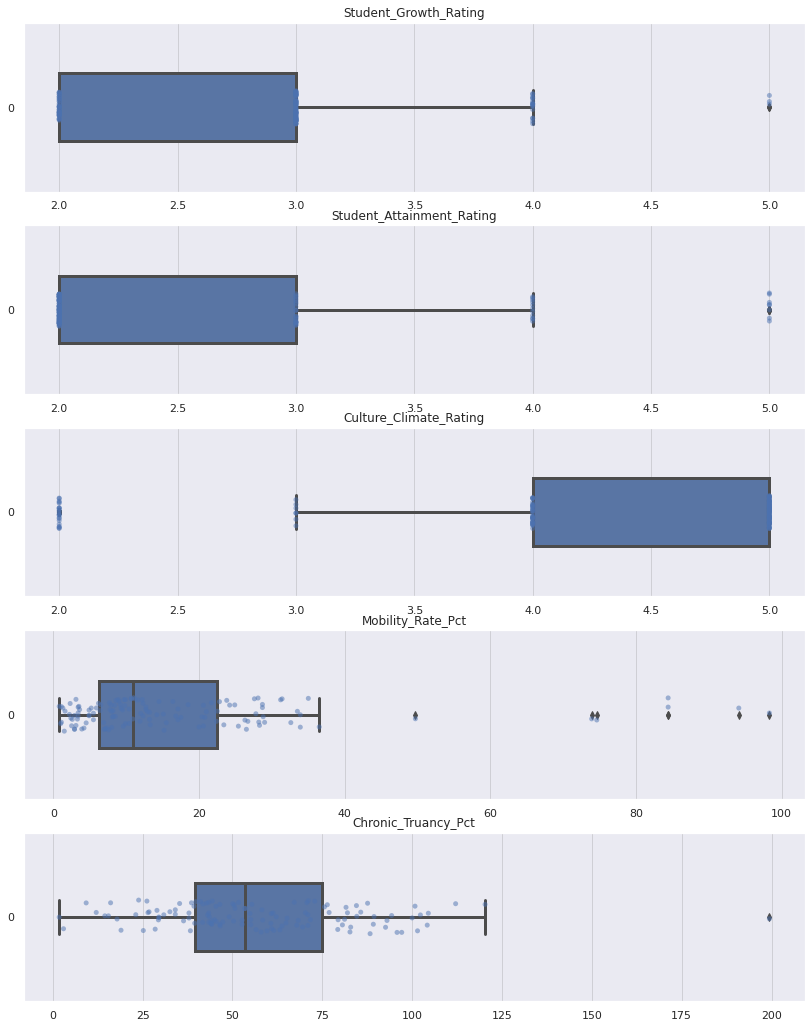

In [1041]:
#Visualize the two featurees
n = 5
fig, ax = plt.subplots(len(df_prepared[0:n]),1,figsize=(14,18),sharex=False, sharey=False)
sns.set_theme()
sns.set(font_scale= 1)

pov_dfs = df_prepared.columns[0:5]

colors = ['autumn_r', 'Oranges_r']

for i in range(0,n):
    ax[i].set_title(f"{pov_dfs[i]}", size = 12)
    ax[i].grid(color='gray', alpha = .5, linestyle='-', linewidth=.5)
    
    sns.boxplot(
                data = df_prepared[pov_dfs[i]],
                width = .4,
                linewidth = 3,
                ax = ax[i],
                orient = "h")

    sns.stripplot(
                alpha = .5, 
                data = df_prepared[pov_dfs[i]],
                ax = ax[i],
                orient = "h")

In [988]:
show_all(df_prepared,5)

School_ID, Short_Name, Long_Name, School_Type, Student_Growth_Rating, 
Student_Attainment_Rating, Culture_Climate_Rating, Mobility_Rate_Pct, Chronic_Truancy_Pct, Growth_PSAT_Grade_9_School_Pct, 
Growth_PSAT_Reading_Grade_10_School_Pct, Growth_SAT_Grade_11_School_Pct, Attainment_PSAT_Grade_9_School_Pct, Attainment_PSAT_Grade_10_School_Pct, Attainment_SAT_Grade_11_School_Pct, 
Attainment_All_Grades_School_Pct, Growth_PSAT_Math_Grade_10_School_Pct, Growth_SAT_Reading_Grade_11_School_Pct, Growth_SAT_Math_Grade_11_School_Pct, Suspensions_Per_100_Students_Year_2_Pct, 
Misconducts_To_Suspensions_Year_2_Pct, Average_Length_Suspension_Year_2_Pct, Student_Attendance_Year_2_Pct, Teacher_Attendance_Year_2_Pct, One_Year_Dropout_Rate_Year_2_Pct, 
Freshmen_On_Track_School_Pct_Year_2, Graduation_4_Year_School_Pct_Year_2, Graduation_5_Year_School_Pct_Year_2, College_Enrollment_School_Pct_Year_2, College_Persistence_School_Pct_Year_2, 
survey_involved_family_num, survey_ambitious_inst_num, survey_effect

In [989]:
df_prepared.corr()

,Student_Growth_Rating,Student_Attainment_Rating,Culture_Climate_Rating,Mobility_Rate_Pct,Chronic_Truancy_Pct,Growth_PSAT_Grade_9_School_Pct,Growth_PSAT_Reading_Grade_10_School_Pct,Growth_SAT_Grade_11_School_Pct,Attainment_PSAT_Grade_9_School_Pct,Attainment_PSAT_Grade_10_School_Pct,Attainment_SAT_Grade_11_School_Pct,Attainment_All_Grades_School_Pct,Growth_PSAT_Math_Grade_10_School_Pct,Growth_SAT_Reading_Grade_11_School_Pct,Growth_SAT_Math_Grade_11_School_Pct,Suspensions_Per_100_Students_Year_2_Pct,Misconducts_To_Suspensions_Year_2_Pct,Average_Length_Suspension_Year_2_Pct,Student_Attendance_Year_2_Pct,Teacher_Attendance_Year_2_Pct,One_Year_Dropout_Rate_Year_2_Pct,Freshmen_On_Track_School_Pct_Year_2,Graduation_4_Year_School_Pct_Year_2,Graduation_5_Year_School_Pct_Year_2,College_Enrollment_School_Pct_Year_2,College_Persistence_School_Pct_Year_2,survey_involved_family_num,survey_ambitious_inst_num,survey_effective_leaders_num,survey_collab_teachers_num,survey_safety_num
Student_Growth_Rating,1.000000,0.325174,0.303425,-0.432111,-0.364447,0.691533,0.398931,0.791062,0.404006,0.493850,0.495956,0.495149,0.626099,0.208796,0.515681,-0.329386,0.007906,-0.013305,0.448934,0.407547,-0.315032,-0.002949,0.420074,0.462164,0.550061,0.429671,0.261657,0.288991,0.086909,0.081056,-0.126372
Student_Attainment_Rating,0.325174,1.000000,0.271198,-0.408271,-0.506708,0.576353,-0.064724,0.497717,0.902324,0.891942,0.923468,0.917518,0.025070,0.029342,0.170446,-0.368247,0.061476,-0.081589,0.379797,0.307597,-0.272376,0.368145,0.451955,0.452381,0.531429,0.604603,0.387338,0.364198,0.047858,0.112474,0.248149
Culture_Climate_Rating,0.303425,0.271198,1.000000,-0.096508,-0.134836,0.302858,0.038888,0.290989,0.238753,0.241819,0.281917,0.271998,0.106842,0.175045,0.161449,-0.036399,0.158332,0.034626,0.272396,0.163742,-0.264662,0.194877,0.149709,0.158947,0.125733,0.171308,0.705270,0.550904,0.669865,0.721408,0.207063
Mobility_Rate_Pct,-0.432111,-0.408271,-0.096508,1.000000,0.812788,-0.639711,-0.024028,-0.507006,-0.647229,-0.619038,-0.526665,-0.572552,-0.149702,0.007996,-0.139552,0.253694,-0.187417,-0.136225,-0.666951,-0.497983,0.870741,-0.443017,-0.794253,-0.806504,-0.762457,-0.730999,-0.208263,-0.122358,0.103772,0.054321,0.095668
Chronic_Truancy_Pct,-0.364447,-0.506708,-0.134836,0.812788,1.000000,-0.672229,-0.003294,-0.553499,-0.698218,-0.660730,-0.629695,-0.663191,-0.142975,0.022282,-0.112030,0.662033,-0.026734,0.173971,-0.809470,-0.406574,0.676331,-0.420744,-0.713193,-0.793656,-0.667172,-0.708061,-0.325567,-0.137721,0.012152,0.007719,-0.064254
Growth_PSAT_Grade_9_School_Pct,0.691533,0.576353,0.302858,-0.639711,-0.672229,1.000000,0.113671,0.822118,0.742315,0.745603,0.711783,0.745483,0.318056,0.050142,0.211562,-0.580189,0.018465,-0.166263,0.629311,0.513658,-0.431679,0.285259,0.514523,0.561177,0.604437,0.638573,0.394405,0.341055,0.077912,0.100041,0.210627
Growth_PSAT_Reading_Grade_10_School_Pct,0.398931,-0.064724,0.038888,-0.024028,-0.003294,0.113671,1.000000,0.280962,-0.122994,0.026341,-0.040701,-0.045329,0.371604,-0.190446,0.173616,0.041480,0.031921,0.075301,0.179172,-0.156112,-0.063058,-0.019636,-0.020568,-0.023438,0.040926,-0.074165,-0.011278,0.189545,0.104395,0.096384,-0.190566
Growth_SAT_Grade_11_School_Pct,0.791062,0.497717,0.290989,-0.507006,-0.553499,0.822118,0.280962,1.000000,0.579530,0.665996,0.674800,0.649120,0.508576,0.074990,0.405274,-0.514224,-0.017080,-0.173829,0.571400,0.408115,-0.324295,0.139721,0.375331,0.476782,0.606178,0.525238,0.348543,0.381098,0.052094,0.083020,0.173304
Attainment_PSAT_Grade_9_School_Pct,0.404006,0.902324,0.238753,-0.647229,-0.698218,0.742315,-0.122994,0.579530,1.000000,0.938053,0.945271,0.980124,0.090538,0.075127,0.180601,-0.579640,0.034026,-0.148856,0.593813,0.416268,-0.440855,0.407262,0.684087,0.703511,0.685039,0.761741,0.427981,0.338253,-0.003702,0.080712,0.346501
Attainment_PSAT_Grade_10_School_Pct,0.493850,0.891942,0.241819,-0.619038,-0.660730,0.745603,0.026341,0.665996,0.938053,1.000000,0.953609,0.979948,0.256348,0.052093,0.

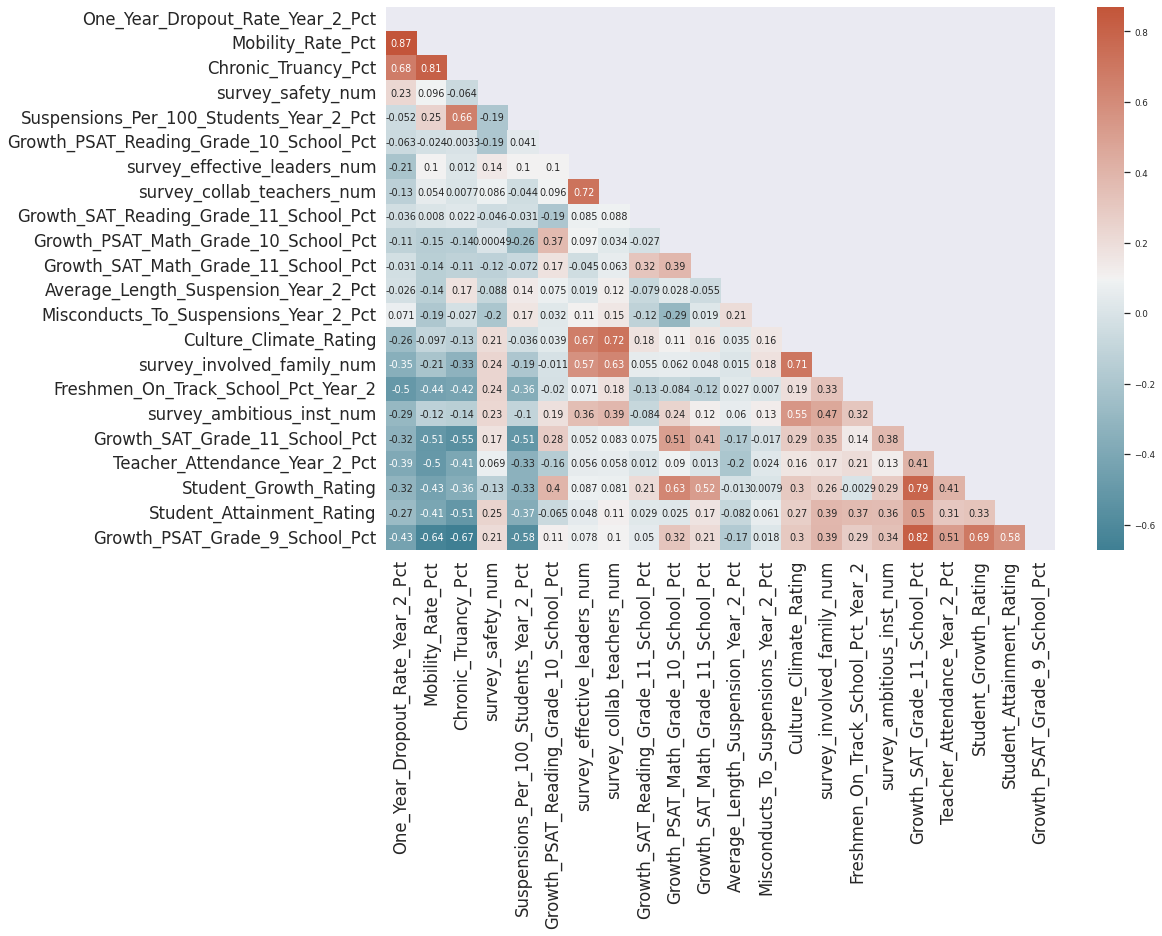

In [990]:
#Create Original Correlation Matrix
corr = df_prepared.corr()
corr["Graduation_4_Year_School_Pct_Year_2"].sort_values(ascending = True)[0]

#Set correlation threshold
corr_thresh = .1

#Select, return, and add features to dataframe
select_features = [corr for corr in corr["Graduation_4_Year_School_Pct_Year_2"].sort_values(ascending = True) if abs(corr) >= corr_thresh]
return_features =  corr["Graduation_4_Year_School_Pct_Year_2"].sort_values(ascending = True)[0:len(select_features)]
to_dataframe = list(return_features.index)
new_df = high_schools[to_dataframe]

#Visualize the results
corr = high_schools[to_dataframe].corr()
plt.subplots(figsize=(15,10))
sns.set(font_scale= .8)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, mask=mask, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))


# IV. Normalize/Standardize/Scale Data
Before moving to Machine Learning models, it's important to ensure that data is consistent and standardized here.

In [991]:
df_prepared.columns[4::]

Index(['Student_Growth_Rating', 'Student_Attainment_Rating',
       'Culture_Climate_Rating', 'Mobility_Rate_Pct', 'Chronic_Truancy_Pct',
       'Growth_PSAT_Grade_9_School_Pct',
       'Growth_PSAT_Reading_Grade_10_School_Pct',
       'Growth_SAT_Grade_11_School_Pct', 'Attainment_PSAT_Grade_9_School_Pct',
       'Attainment_PSAT_Grade_10_School_Pct',
       'Attainment_SAT_Grade_11_School_Pct',
       'Attainment_All_Grades_School_Pct',
       'Growth_PSAT_Math_Grade_10_School_Pct',
       'Growth_SAT_Reading_Grade_11_School_Pct',
       'Growth_SAT_Math_Grade_11_School_Pct',
       'Suspensions_Per_100_Students_Year_2_Pct',
       'Misconducts_To_Suspensions_Year_2_Pct',
       'Average_Length_Suspension_Year_2_Pct', 'Student_Attendance_Year_2_Pct',
       'Teacher_Attendance_Year_2_Pct', 'One_Year_Dropout_Rate_Year_2_Pct',
       'Freshmen_On_Track_School_Pct_Year_2',
       'Graduation_4_Year_School_Pct_Year_2',
       'Graduation_5_Year_School_Pct_Year_2',
       'College_Enrollme

In [992]:
#Create Features and Target
df_features = df_prepared.drop(columns = ['Graduation_4_Year_School_Pct_Year_2', 
                                          'Graduation_5_Year_School_Pct_Year_2',
                                          'School_ID','Short_Name',
                                          'Long_Name',
                                          'School_Type'])

df_target = df_prepared['Graduation_4_Year_School_Pct_Year_2'].fillna(df_prepared['Graduation_4_Year_School_Pct_Year_2'].mean())

# V. Machine Learning Models

In [993]:
'''
#Break Graduation Rates into Four Categories
categorized_graduation_rates = []

for elem in high_schools.Graduation_4_Year_School_Pct_Year_2:
    if elem >= 75:
        categorized_graduation_rates.append(3)
    elif elem >= 50 and elem < 75:
        categorized_graduation_rates.append(2)
    elif elem > 25 and elem < 50:
        categorized_graduation_rates.append(1)
    else:
        categorized_graduation_rates.append(0)

categorized_graduation_rates[0:10]
'''

'\n#Break Graduation Rates into Four Categories\ncategorized_graduation_rates = []\n\nfor elem in high_schools.Graduation_4_Year_School_Pct_Year_2:\n    if elem >= 75:\n        categorized_graduation_rates.append(3)\n    elif elem >= 50 and elem < 75:\n        categorized_graduation_rates.append(2)\n    elif elem > 25 and elem < 50:\n        categorized_graduation_rates.append(1)\n    else:\n        categorized_graduation_rates.append(0)\n\ncategorized_graduation_rates[0:10]\n'

In [994]:
#Break Graduation Rates into Four Categories
categorized_graduation_rates = []

for elem in high_schools.Graduation_4_Year_School_Pct_Year_2:
    if elem >= 85:
        categorized_graduation_rates.append(1)
    else:
        categorized_graduation_rates.append(0)

categorized_graduation_rates[0:10]

[0, 0, 0, 0, 0, 1, 0, 1, 1, 1]

In [995]:
df_prepared['target_graduation'] = pd.Series(categorized_graduation_rates)
cor = df_prepared.corr()
corr = abs(cor['target_graduation'])

relevant_features = corr[corr>0.1]
df_prepared = df_prepared[relevant_features.index]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [996]:
#Convert Scaled Data to pd.data
from sklearn.preprocessing import MinMaxScaler
data = df_prepared
scaler = MinMaxScaler()

scaled_data = scaler.fit_transform(data)

df_scaled = pd.DataFrame(scaled_data)
df_scaled.fillna(df_scaled.mean(), inplace = True)

#Make sure to bring back column labels here.
df_scaled.columns = df_prepared.columns

In [997]:
df_scaled.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140 entries, 0 to 139
Data columns (total 27 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Student_Growth_Rating                    140 non-null    float64
 1   Student_Attainment_Rating                140 non-null    float64
 2   Culture_Climate_Rating                   140 non-null    float64
 3   Mobility_Rate_Pct                        140 non-null    float64
 4   Chronic_Truancy_Pct                      140 non-null    float64
 5   Growth_PSAT_Grade_9_School_Pct           140 non-null    float64
 6   Growth_SAT_Grade_11_School_Pct           140 non-null    float64
 7   Attainment_PSAT_Grade_9_School_Pct       140 non-null    float64
 8   Attainment_PSAT_Grade_10_School_Pct      140 non-null    float64
 9   Attainment_SAT_Grade_11_School_Pct       140 non-null    float64
 10  Attainment_All_Grades_School_Pct         140 non-n

In [998]:
#df_scaled.fillna(df_scaled.mean())

In [999]:
df_scaled.columns

Index(['Student_Growth_Rating', 'Student_Attainment_Rating',
       'Culture_Climate_Rating', 'Mobility_Rate_Pct', 'Chronic_Truancy_Pct',
       'Growth_PSAT_Grade_9_School_Pct', 'Growth_SAT_Grade_11_School_Pct',
       'Attainment_PSAT_Grade_9_School_Pct',
       'Attainment_PSAT_Grade_10_School_Pct',
       'Attainment_SAT_Grade_11_School_Pct',
       'Attainment_All_Grades_School_Pct',
       'Suspensions_Per_100_Students_Year_2_Pct',
       'Misconducts_To_Suspensions_Year_2_Pct',
       'Student_Attendance_Year_2_Pct', 'Teacher_Attendance_Year_2_Pct',
       'One_Year_Dropout_Rate_Year_2_Pct',
       'Freshmen_On_Track_School_Pct_Year_2',
       'Graduation_4_Year_School_Pct_Year_2',
       'Graduation_5_Year_School_Pct_Year_2',
       'College_Enrollment_School_Pct_Year_2',
       'College_Persistence_School_Pct_Year_2', 'survey_involved_family_num',
       'survey_ambitious_inst_num', 'survey_effective_leaders_num',
       'survey_collab_teachers_num', 'survey_safety_num', 'targ

In [1000]:
df_scaled.drop(columns = ['Graduation_4_Year_School_Pct_Year_2', 
                          'Graduation_5_Year_School_Pct_Year_2', 
                          'target_graduation',
                          'College_Enrollment_School_Pct_Year_2',
                          'College_Persistence_School_Pct_Year_2'], inplace = True)

In [1001]:
df_scaled.columns

Index(['Student_Growth_Rating', 'Student_Attainment_Rating',
       'Culture_Climate_Rating', 'Mobility_Rate_Pct', 'Chronic_Truancy_Pct',
       'Growth_PSAT_Grade_9_School_Pct', 'Growth_SAT_Grade_11_School_Pct',
       'Attainment_PSAT_Grade_9_School_Pct',
       'Attainment_PSAT_Grade_10_School_Pct',
       'Attainment_SAT_Grade_11_School_Pct',
       'Attainment_All_Grades_School_Pct',
       'Suspensions_Per_100_Students_Year_2_Pct',
       'Misconducts_To_Suspensions_Year_2_Pct',
       'Student_Attendance_Year_2_Pct', 'Teacher_Attendance_Year_2_Pct',
       'One_Year_Dropout_Rate_Year_2_Pct',
       'Freshmen_On_Track_School_Pct_Year_2', 'survey_involved_family_num',
       'survey_ambitious_inst_num', 'survey_effective_leaders_num',
       'survey_collab_teachers_num', 'survey_safety_num'],
      dtype='object')

In [1002]:
df_target = pd.DataFrame(categorized_graduation_rates)

X = df_scaled
y = df_target

#Distributions of Scaled Features

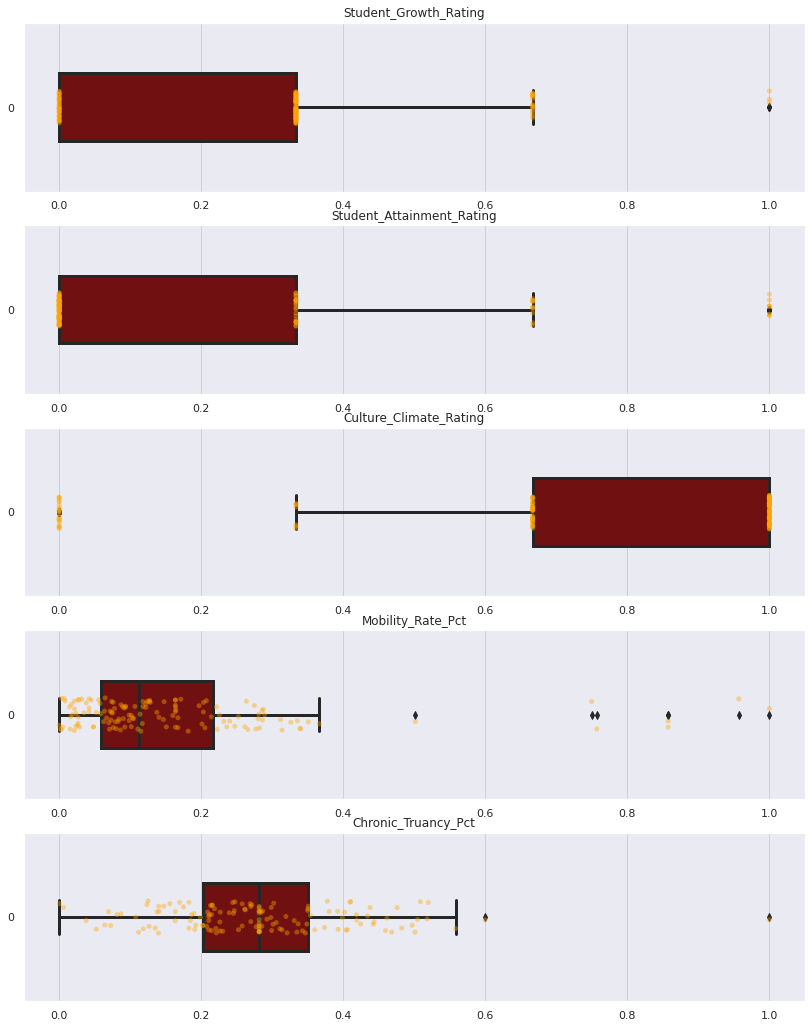

In [1070]:
#Visualize the two featurees
n = 5
fig, ax = plt.subplots(len(df_scaled[0:n]),1,figsize=(14,18),sharex=False, sharey=False)
sns.set_theme('poster')
sns.set_style('darkgrid')
sns.set(font_scale= 1)

pov_dfs = df_scaled.columns[0:5]

colors = ['autumn_r', 'Oranges_r']

for i in range(0,n):
    ax[i].set_title(f"{pov_dfs[i]}", size = 12)
    ax[i].grid(color='gray', alpha = .5, linestyle='-', linewidth=.5)
    
    sns.boxplot(
                data = df_scaled[pov_dfs[i]],
                width = .4,
                linewidth = 3,
                ax = ax[i],
                color = 'maroon',
                orient = "h")

    sns.stripplot(
                alpha = .4, 
                data = df_scaled[pov_dfs[i]],
                ax = ax[i],
                color = 'orange',
                orient = "h")

# VI. Model Comparisons
This will attempt to learn from classification, etc.

In [1003]:
import random

In [1004]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=1)

n = random.randint(0,10)
print(f"Var Random State = {n}")

Var Random State = 2


In [1005]:
#Let's start with logistic regression
from sklearn.linear_model import LogisticRegression
log_model = LogisticRegression(random_state= n).fit(X_train, 
                                                    y_train)
y_pred_logreg = log_model.predict(X_test)
print(classification_report(y_test, y_pred_logreg))

              precision    recall  f1-score   support

           0       0.83      0.97      0.90        31
           1       0.83      0.45      0.59        11

    accuracy                           0.83        42
   macro avg       0.83      0.71      0.74        42
weighted avg       0.83      0.83      0.82        42



/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.786


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


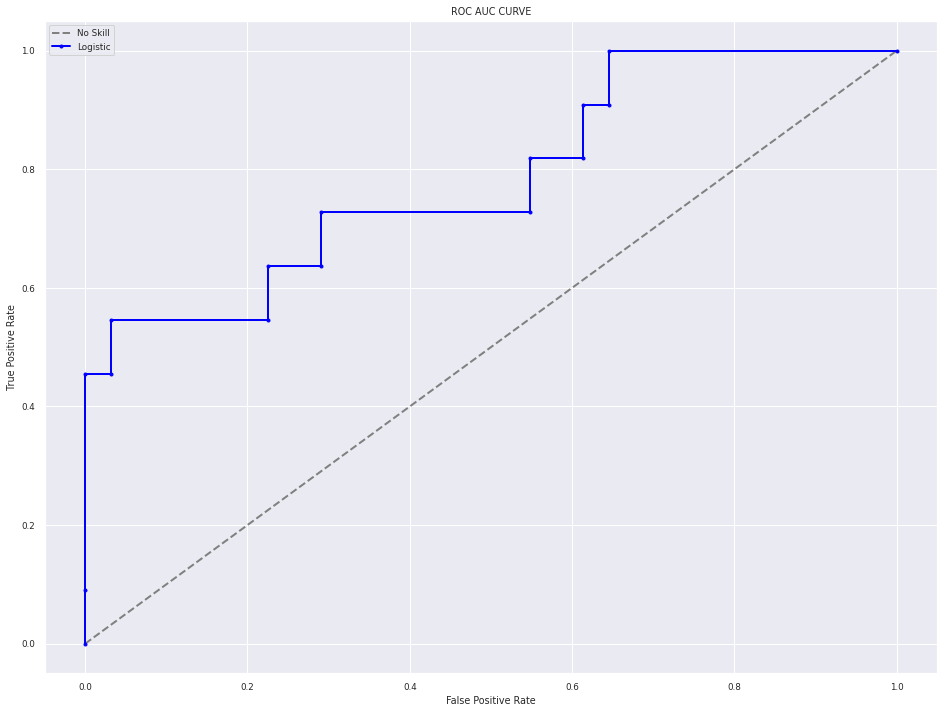

In [1006]:
# roc curve and auc
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
# generate 2 class dataset

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
# fit a model
model = LogisticRegression(random_state = n)
model.fit(X_train, y_train)
# predict probabilities
lr_probs = model.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))

fig, ax = plt.subplots(figsize = (16,12))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linewidth = 2, linestyle='--', color = 'gray', label='No Skill')
plt.plot(lr_fpr, lr_tpr, linewidth = 2, marker='.', color = 'blue', label='Logistic')
# axis labels
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC AUC CURVE')
# show the legend
plt.legend()
# show the plot
plt.show()

In [1007]:
len(df_scaled.columns)

22

In [1008]:
#Try a Decision tree Model
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier

decision_tree_classifier = DecisionTreeClassifier(random_state= n)
decision_tree_classifier.fit(X_train, y_train)
y_pred_tree = decision_tree_classifier.predict(X_test)
print(classification_report(y_test, y_pred_tree))

              precision    recall  f1-score   support

           0       0.83      0.65      0.73        31
           1       0.39      0.64      0.48        11

    accuracy                           0.64        42
   macro avg       0.61      0.64      0.61        42
weighted avg       0.72      0.64      0.66        42



              precision    recall  f1-score   support

           0       0.84      0.84      0.84        31
           1       0.55      0.55      0.55        11

    accuracy                           0.76        42
   macro avg       0.69      0.69      0.69        42
weighted avg       0.76      0.76      0.76        42



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


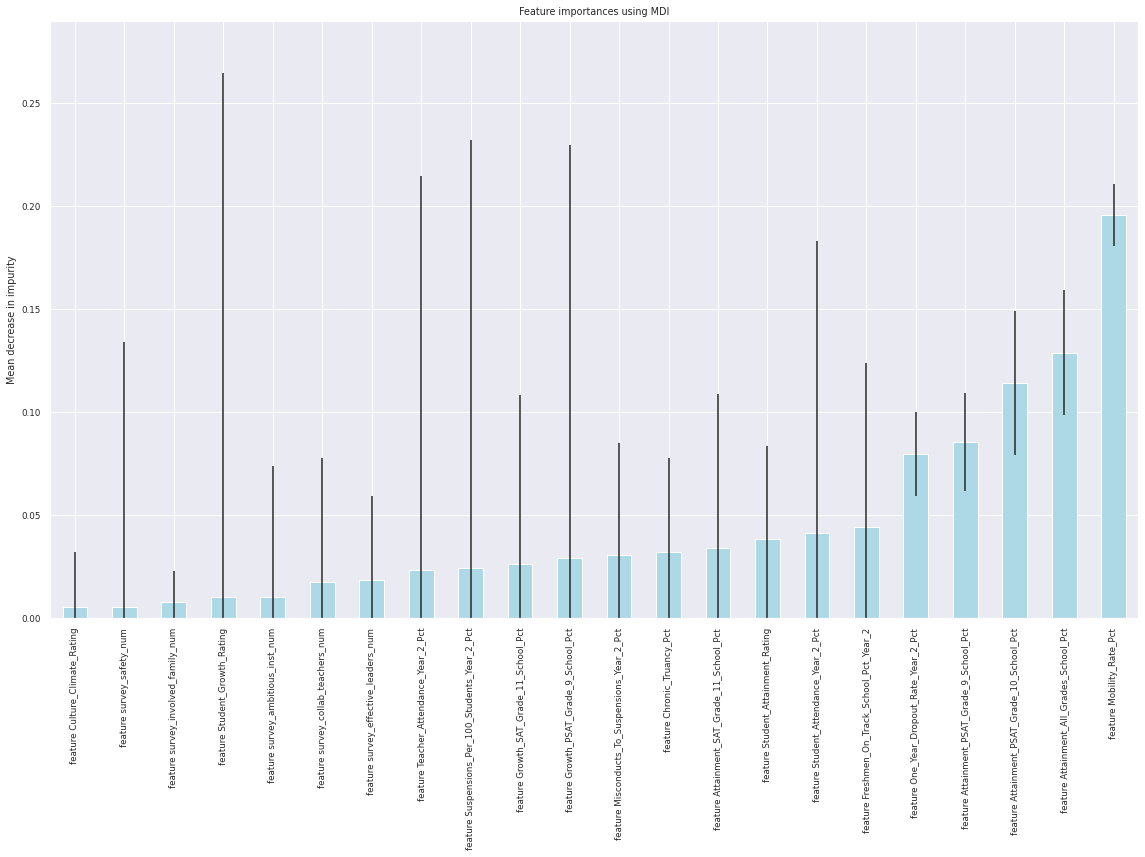

In [1009]:
#Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
feature_names = [f"feature {i}" for i in df_scaled.columns]

forest = RandomForestClassifier(random_state= n)
forest.fit(X_train, y_train)
forest_pred = forest.predict(X_test)
print(classification_report(y_test, forest_pred))

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

forest_importances = pd.Series(importances, index=feature_names).sort_values()

fig, ax = plt.subplots(figsize = (16,12))
forest_importances.plot.bar(yerr=std, ax=ax, color = 'lightblue')
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
ax.set_ylim(0)
fig.tight_layout()

In [1010]:
#ADA Prediction
from sklearn.ensemble import AdaBoostClassifier
ada_classifier = AdaBoostClassifier(random_state=n)
ada_classifier.fit(X_train, y_train)
ada_pred = ada_classifier.predict(X_test)
print(classification_report(y_test, ada_pred))

              precision    recall  f1-score   support

           0       0.79      0.74      0.77        31
           1       0.38      0.45      0.42        11

    accuracy                           0.67        42
   macro avg       0.59      0.60      0.59        42
weighted avg       0.69      0.67      0.68        42



/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0       0.81      0.81      0.81        31
           1       0.45      0.45      0.45        11

    accuracy                           0.71        42
   macro avg       0.63      0.63      0.63        42
weighted avg       0.71      0.71      0.71        42



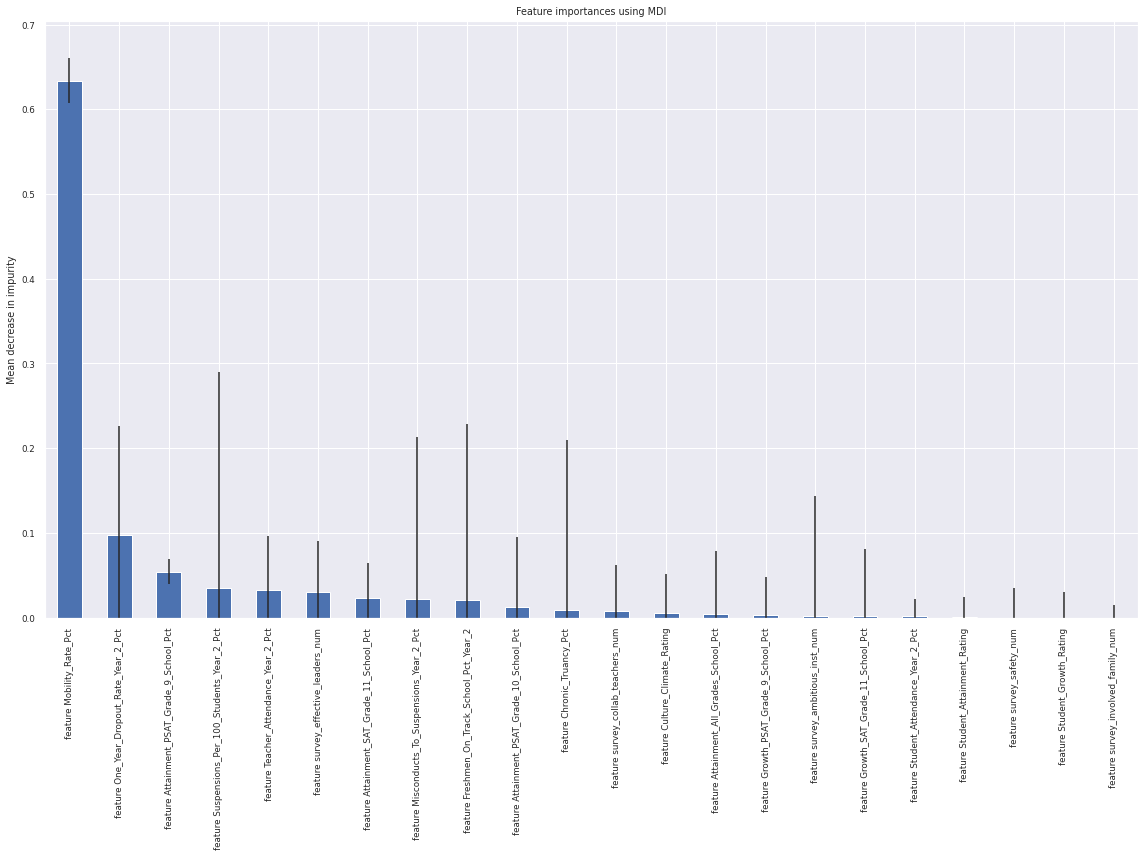

In [1011]:
#Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier
GB_classifier = GradientBoostingClassifier(random_state=n)
GB_classifier.fit(X_train, y_train)
GB_pred = GB_classifier.predict(X_test)
print(classification_report(y_test, GB_pred))

importances = GB_classifier.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

forest_importances = pd.Series(importances, index=feature_names).sort_values(ascending = False)

fig, ax = plt.subplots(figsize = (16,12))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
ax.set_ylim(0)
fig.tight_layout()

In [1012]:
#XGB Classifier
import xgboost as xgb
XGB_classifier = xgb.XGBClassifier(random_state=n)
XGB_classifier.fit(X_train, y_train)

xgb_pred = XGB_classifier.predict(X_test)
print(classification_report(y_test, xgb_pred))

              precision    recall  f1-score   support

           0       0.81      0.94      0.87        31
           1       0.67      0.36      0.47        11

    accuracy                           0.79        42
   macro avg       0.74      0.65      0.67        42
weighted avg       0.77      0.79      0.76        42



/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Analyzing the model

In [1013]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering

from sklearn.datasets import make_blobs


from sklearn.metrics import accuracy_score

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

from sklearn.metrics import silhouette_score
from sklearn.metrics import v_measure_score, completeness_score, homogeneity_score
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph

# VII. Conclusions
Boosting Data